## Header

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import scipy

import statsmodels as sm
import statsmodels.formula.api as smf
from patsy.contrasts import ContrastMatrix
import patsy

import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import seaborn as sns

from IPython.display import display

from functools import partial

from utils.multi_processing_functions import *

PLOT_PATH = './plots_grasp_aligned_fixations_final/'
PROCESSED_DATA_PATH = '../processed_data/EIH_1/'

In [2]:
import multiprocessing as mp

def pandas_mp_apply(grouped_df, apply_func):
    with mp.Pool(mp.cpu_count() - 1) as p:
        ret_list = p.map(apply_func, [(group, name) for name, group in grouped_df])
    
    return pd.concat(ret_list)

In [3]:
sns.set(palette='muted', context='talk', style='ticks')
scpt = sns.color_palette()

## Read data file

In [5]:
samples_df = pd.read_csv(
    '../processed_data/EIH_1/05_ET_samples_graspInfo.csv',
    parse_dates = ['timestamp_dt'],
    dtype = {
        'isFixV': np.bool, 'grasp_onset_bool': np.bool,'grasp_end_bool': np.bool,
#         'subjectID': 'int32', 'trial_num': 'int32', 'trialID': 'int32',
    },
    index_col=False,
)
samples_df.head()

,timestamp_dt,combinedEye_position_x,combinedEye_position_y,combinedEye_position_z,combinedEye_direction_x,combinedEye_direction_y,combinedEye_direction_z,combinedEye_raycastHitObject,combinedEye_raycastHitLocation_x,combinedEye_raycastHitLocation_y,...,fix_stop,fix_onset_bool,fix_stop_bool,grasp_onset,grasp_stop,grasp_duration,grasp_onset_bool,grasp_end_bool,pickup_location,drop_location
0,2019-09-25 08:40:09+00:00,-0.005455,-0.003011,-0.022980,-0.140977,-0.052399,0.988625,Cube_Blue,-0.759600,1.501493,...,2019-09-25 08:40:09+00:00,False,False,2019-09-25 08:40:09+00:00,2019-09-25 08:40:09+00:00,0.0,False,False,NaN,NaN
1,2019-09-25 08:40:10+00:00,0.012969,-0.001406,-0.024224,0.043320,-0.255784,0.965763,Sphere_Red,-0.089958,1.121638,...,2019-09-25 08:40:57+00:00,True,False,2019-09-25 08:40:10+00:00,2019-09-25 08:40:10+00:00,0.0,False,False,NaN,NaN
2,2019-09-25 08:40:11+00:00,0.003722,-0.001710,-0.023133,0.037643,-0.015106,0.999177,Cube_Blue,-0.830570,1.490419,...,2019-09-25 08:40:57+00:00,False,False,2019-09-25 08:40:11+00:00,2019-09-25 08:40:11+00:00,0.0,False,False,NaN,NaN
3,2019-09-25 08:40:12+00:00,0.017633,-0.000281,-0.024600,0.080307,-0.156388,0.984425,Floor,-0.747835,1.358000,...,2019-09-25 08:40:57+00:00,False,False,2019-09-25 08:40:12+00:00,2019-09-25 08:40:14+00:00,2.0,True,False,2_1,NaN
4,2019-09-25 08:40:13+00:00,0.014563,-0.000925,-0.022753,0.295460,-0.054566,0.953795,Cube_Red,0.917458,1.096737,...,2019-09-25 08:40:57+00:00,False,False,2019-09-25 08:40:12+00:00,2019-09-25 08:40:14+00:00,2.0,False,False,NaN,NaN


In [6]:
samples_df.shape

(114943, 71)

In [11]:
samples_df = samples_df.rename(columns = {
    'subjectID': 'subject_id',
#     'trialNum' : 'trial_num',
    'combinedEye_raycastHitObject' : 'eye_hit',
    'eye_shelfHits' : 'eye_shelf_hit',
    'trialID' : 'trial_id',
    'isFixV' : 'is_fixation',
    'nosePointer_shelfHits' : 'head_hit',
    'isOutlierFix' : 'is_outlier_fixation',
    'handData_graspedObject' : 'grasp'
    
})
print(samples_df.shape)
print(samples_df.query('eye_shelf_hit == "ERROR"').shape)

samples_df = (
    samples_df
    .query('subject_id not in [2008, 2011, 2039, 2034, 2042, 2046]')
    .query('eye_shelf_hit != "ERROR"')
    .query('subject_id != 2022 and trial_num != 0')
    .query('subject_id != 2044 and trial_num != 1')
)

samples_df.loc[
    (
        (samples_df.subject_id == 2040)
        & (samples_df.subjectfileName.str.endswith('_2.etd'))
    ), 'trial_num'
] += 3

samples_df['trial_type'] = (
    samples_df
    .trial_id
    .apply(lambda s: 'easy' if s in np.arange(0,8) else 'hard')
)

samples_df = samples_df[[
    'subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation', 'eye_hit', 'grasp',
    'grasp_onset_bool', 'eye_shelf_hit', 'fix_duration', 'grasp_end_bool', 'grasp_duration', 
    'is_outlier_fixation', 'pickup_location', 'drop_location'
]]

valid_objs = ['Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow',
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow',
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow']

samples_df.loc[~(samples_df.eye_hit.isin(valid_objs)) & 
           ~(pd.isnull(samples_df.eye_hit)),
               'eye_hit'] ='Other'

(10153442, 71)
(0, 71)


In [5]:
samples_df.head()

,subject_id,trial_num,trial_type,timestamp_dt,is_fixation,eye_hit,grasp,grasp_onset_bool,eye_shelf_hit,fix_duration,grasp_end_bool,grasp_duration,is_outlier_fixation,pickup_location,drop_location
8905,2006.0,2.0,hard,1970-01-01 00:00:00.351460844,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8906,2006.0,2.0,hard,1970-01-01 00:00:00.360775739,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8907,2006.0,2.0,hard,1970-01-01 00:00:00.371934354,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8908,2006.0,2.0,hard,1970-01-01 00:00:00.383572042,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN
8909,2006.0,2.0,hard,1970-01-01 00:00:00.394215554,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN


In [ ]:
subjects = np.arange(2005, 2066, 2)
samples_df = samples_df.query('subject_id in @subjects')

In [7]:
samples_df.columns

Index(['subject_id', 'trial_num', 'trial_type', 'timestamp_dt', 'is_fixation',
       'eye_hit', 'grasp', 'grasp_onset_bool', 'eye_shelf_hit', 'fix_duration',
       'grasp_end_bool', 'grasp_duration', 'is_outlier_fixation',
       'pickup_location', 'drop_location'],
      dtype='object')

In [9]:
shelf_df = pd.read_csv(f'{PROCESSED_DATA_PATH}/00_ET_shelfData_master.csv')
shelf_df.fillna(value={'shape':'Sphere',
                        'color':'Red', 
                        'position.x':0, 
                        'position.y':0, 
                        'trialID':0}, 
                inplace=True)
shelf_df['position_x'] = shelf_df['position_x'].astype(int) + 1
shelf_df['position_y'] = shelf_df['position_y'].astype(int) + 1
shelf_df['shelfID'] = shelf_df['position_y'].astype(str) + '_' + shelf_df['position_x'].astype(str)
shelf_df['object'] = shelf_df['shape'] + '_' + shelf_df['color']
# shelf_df.rename(columns={'position.x': 'pos_x', 'position.y':'pos_y'}, inplace=True)
display(shelf_df.head())

,shape,position_x,position_y,color,trialID,subjectID,subjectfileName,trialNum,shelfID,object
0,Cube,5,3,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,3_5,Cube_Red
1,Cylinder,1,5,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,5_1,Cylinder_Red
2,Sphere,3,3,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,3_3,Sphere_Red
3,Tetraeder,5,4,Red,0.0,2006,../experiment_et_data\subject2006.etd,0,4_5,Tetraeder_Red
4,Cube,1,2,Blue,0.0,2006,../experiment_et_data\subject2006.etd,0,2_1,Cube_Blue


## TODO
* remove saccadic samples
* group object and shelf related samples
* remove short less than 7 sample groups
* label sample groups based on previous grasped object, current grasped object, next grasped object, previous target shelf, current target shelf, next target shelf
* create 6x6 transition matrix for each trial, each subject and grand average


In [8]:
samples_df.is_fixation.value_counts(normalize=True)

True     0.796479
False    0.203521
Name: is_fixation, dtype: float64

In [5]:
# samples_df.set_index(t)
samples_df['time_from_start'] = (
    samples_df
    .groupby(['subject_id','trial_num',], as_index=False)
    .timestamp_dt
    .transform(lambda x: (x.values - x.values[0])/np.timedelta64(1,'s'))
)
samples_df.head()

,subject_id,trial_num,trial_type,timestamp_dt,is_fixation,eye_hit,grasp,grasp_onset_bool,eye_shelf_hit,fix_duration,grasp_end_bool,grasp_duration,is_outlier_fixation,pickup_location,drop_location,time_from_start
8905,2006.0,2.0,hard,1970-01-01 00:00:00.351460844,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN,0.000000
8906,2006.0,2.0,hard,1970-01-01 00:00:00.360775739,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN,0.009315
8907,2006.0,2.0,hard,1970-01-01 00:00:00.371934354,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN,0.020474
8908,2006.0,2.0,hard,1970-01-01 00:00:00.383572042,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN,0.032111
8909,2006.0,2.0,hard,1970-01-01 00:00:00.394215554,True,Other,NaN,False,2_4,0.464886,False,0.0,False,NaN,NaN,0.042755


In [ ]:
subject=2010
trial=13
tmpdf = (
    samples_df
    .query('subject_id == @subject & trial_num == @trial')
    .query('time_from_start <=40')
)
# display(tmpdf.eye_hit.to_list())
# display(tmpdf.eye_shelf_hit.values)
shelf_dict = {
    k:v 
    for k,v in 
    zip(
        sorted(samples_df.query('eye_shelf_hit!="ERROR"').eye_shelf_hit.dropna().unique()), 
        np.arange(0,25)
       )
}
objs_dict = {
    'Other':0, 'Cube_Blue': 1, 'Cube_Green':2, 'Cube_Red':3,
    'Cube_Yellow':4, 'Cylinder_Blue':5,
    'Cylinder_Green':6, 'Cylinder_Red':7,
    'Cylinder_Yellow':8, 'Sphere_Blue':9, 'Sphere_Green':10,
    'Sphere_Red':11, 'Sphere_Yellow':12, 'Tetraeder_Blue':13,
    'Tetraeder_Green':14,'Tetraeder_Red':15, 'Tetraeder_Yellow':16
}

tmpdf['eye_shelf_hit'] = tmpdf['eye_shelf_hit'].map(shelf_dict)  
# tmpdf['eye_hit'] = tmpdf['eye_hit'].map(objs_dict)
#     display(tmpdf.query('eyeHit==@obj').eye_shelfHits.unique())
# tmpdf['eyeHitObj'] = np.nan
tmpdf.loc[tmpdf.eye_hit != 'Other', ['eye_hit']] = tmpdf.query('eye_hit != "Other"').eye_shelf_hit
# tmpdf.loc[tmpdf.eye_hit == 0, ['eye_hit']] = tmpdf.query('eye_hit == 0').eye_shelf_hit
tmpdf.loc[tmpdf.eye_hit == "Other", ['eye_hit']] = np.nan
# tmpdf.loc[tmpdf.is_fixation == 0, ['eye_hit']] = np.nan
# tmpdf.loc[tmpdf.is_fixation == 0, ['eye_shelf_hit']] = np.nan

# time = tmpdf.loc[tmpdf.query('grasp_onset_bool==1').index[0],'time_from_start']
# display(tmpdf.loc[(tmpdf.time_from_start>time+0.5) & (tmpdf.time_from_start<time+1) ,['grasp','eye_hit','is_fixation', 'fix_stop_bool']])

sns.set(context = "talk", style="whitegrid", palette="dark", font_scale=1, rc={'figure.figsize':(11.7,8.27)})
_, ax = plt.subplots(figsize=(30,10))

ax.set_yticklabels(shelf_dict.keys())

ax.scatter(tmpdf.time_from_start, tmpdf.eye_shelf_hit, color = 'r', alpha=0.4, label='shelf fixation', marker='s')

ax.scatter(tmpdf.time_from_start, tmpdf.eye_hit, color = 'g', alpha=0.8, label='object fixation', marker='.')



for i, val in tmpdf.iterrows():
    if val.grasp_onset_bool:
        print(val.grasp, val.pickup_location)
        plt.axvline(val.time_from_start, color='k')
        plt.text(val.time_from_start-0.9,20, val.grasp, {'color': 'k', 'fontsize': 18}, rotation=90,)
        plt.text(val.time_from_start-0.9,12, val.pickup_location, {'color': 'k', 'fontsize': 18}, rotation=90,)

    if val.grasp_end_bool:
        print(val.drop_location)
        plt.axvline(val.time_from_start, color='k', ls=':')
        
        plt.text(val.time_from_start-0.9,18, val.drop_location, {'color': 'k', 'fontsize': 18}, rotation=90,)
        
#     if val.objFix_onset_bool:
        
#         plt.axvline(val.time_from_start, color='lightsteelblue', ls='-', alpha=0.5)
#     if val.fix_stop_bool:
#         plt.axvline(val.timeFromStart, color='k', ls='--')



tmpdf = shelf_df.query('subjectID == @subject & trialNum == @trial ')
tmpdf.shelfID = tmpdf['shelfID'].map(shelf_dict)  
# display(tmpdf)
for i, val in tmpdf.iterrows():
    plt.text(-2,val.shelfID, val.object, {'color': 'k', 'fontsize': 12}, rotation=0,)

ax.set_yticks(np.arange(0, 25))
ax.set_ylim(-1,25)
ax.set_xlabel('Time (sec)')
ax.set_ylabel('Shelf Location')
ax.legend(loc='upper right', frameon=False, bbox_to_anchor=(0.9, 1.15), fontsize=25)
ax.set_title(f'Fix Samples on Shelf & Objects vs. Time (Subject-{subject}, Trial = {trial}, type= {tmpdf.trialID.unique()})')
plt.show()
# plt.savefig(f'{PLOT_PATH}/Fix_shelf_obj_{subject}_{trial}.png', transparent=False, bbox_inches='tight', quality=90)

## calculate object fixation durations

In [15]:
# samples_df = samples_df.sort_values('timestamp_dt')
# samples_df.set_index('timestamp_dt', inplace=True)

samples_df.loc[samples_df.is_fixation == 0, 'eye_hit'] = np.nan

samples_df['obj_fix_dur'] = (
    samples_df
#     .reset_index()
    .groupby(['subject_id', 'trial_num'], as_index=False)
    .eye_hit
    .apply(lambda x:
           x.groupby((x != x.shift()).cumsum())
           .transform(lambda x:
                      (x.index[-1] - x.index[0]) #/np.timedelta64(1, 's')
                     )
          )
).reset_index().set_index('timestamp_dt').eye_hit

samples_df.head()

ValueError: cannot reindex from a duplicate axis

In [ ]:
samples_df.obj_fix_dur.describe()

In [ ]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1, rc={'figure.figsize':(5,5)})

ax = (
    samples_df
    .query('eye_hit != "Other" and obj_fix_dur > 0.15')
    .obj_fix_dur
    .plot(kind='hist', bins=100, histtype='step', density=True, color='r', label='Object fix duration' )
)
(
    samples_df
    .query('eye_hit == "Other" and obj_fix_dur > 0.15')
    .obj_fix_dur
    .plot(kind='hist', bins=100, histtype='step', density=True, color='b', label='Shelf fix duration', ax=ax,)
)
ax.set(
    xlabel = 'fixation duration (s)',
#     ylim = (0,2.5),
    xlim = (0,1.5),
#     yticks = np.arange(0,2.1,1)
)
ax.legend(bbox_to_anchor=(0.8,0.6), frameon=False)
sns.despine(offset=10)

# Transition matrices

### transition matrix plotting

In [ ]:
def plot_net_transition_per_trial(tm_df, PLOT_PATH, plot=False):    
    
    os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)    
    
    sym_dict = {'trial_num': [], 'grasp_num': [], 'sym_index': [], 'trial_type': [], 'entropy':[]}
     
    for trial_num in tm_df.trial_num.unique():
        tmpdf = (
            tm_df
            .query('trial_num == @trial_num')
            .query('is_fixation == True and obj_fix_dur > 0.15 and obj_fix_dur <= 2 ')
            .drop_duplicates(subset=['is_fixation', 'obj_fix_dur', 'fix_type', 'eye_hit'], keep='first')
            [['trial_num', 'fix_type', 'grasp_num', 'trial_type']]
        )
    
        trial_type = tmpdf.trial_type.unique()[0]
        grasp_num = tmpdf.grasp_num.max()        
        tmpdf.dropna(subset=['fix_type'], inplace=True)
        
        tmpdf['fix_type_destination'] = tmpdf.groupby(['grasp_num']).fix_type.shift(-1)

        tmpdf = (
            tmpdf
            .groupby(['fix_type', 'fix_type_destination'])
            .size()
            .rename('num_switch')
            .reset_index()
        )
        tmpdf.loc[tmpdf.fix_type == tmpdf.fix_type_destination, 'num_switch'] = 0

        tmpdf = tmpdf.pivot(index='fix_type', columns = 'fix_type_destination', values='num_switch')
        
        columns = ['prev_TO', 'prev_TS', 'current_TO', 'current_TS', 'next_TO', 'next_TS', 'other']
#         print(tmpdf.columns, tmpdf.index.values)
        for col in columns:
            if col not in tmpdf.index.values or col not in tmpdf.columns:
                tmpdf.loc[col, col] = 0 
                
#         print(tmpdf.columns, tmpdf.index.values)
        tmpdf = tmpdf.reindex(
            [
                'prev_TO', 'prev_TS',
                'current_TO', 'current_TS', 
                'next_TO','next_TS',          
                'other'
            ]
        )
        
        tmpdf = tmpdf.loc[:, [
                'prev_TO', 'prev_TS',
                'current_TO', 'current_TS', 
                'next_TO','next_TS',          
                'other'
        ]]
        
#         print(tmpdf)
#         if normalize:
#             tmpdf = tmpdf.div(tmpdf.sum(axis=1), axis=0)
# #             tmpdf = tmpdf.div(tmpdf.sum(axis=1).sum())

#        
        tmpdf = tmpdf.fillna(0)
        
        A_net = (tmpdf - tmpdf.T)
        A_total = (tmpdf + tmpdf.T)        
        
        F = (np.tril(abs(A_net.to_numpy())).sum())/(np.tril(A_total.to_numpy()).sum())
        
        Px = tmpdf.div(tmpdf.sum(axis=1), axis=0) 
        Px = Px.fillna(0).to_numpy() 
        logPx = np.log2(Px)
        logPx[logPx == -np.inf] = np.nan
        logPx[logPx == np.inf] = np.nan
        entropy = -np.nansum((np.nansum((Px*logPx), axis=1)), axis=0)
        
#         print(Px, np.log2(Px))
        
        sym_dict['trial_num'].append(trial_num)
        sym_dict['sym_index'].append(F)
        sym_dict['trial_type'].append(trial_type)
        sym_dict['grasp_num'].append(grasp_num)
        sym_dict['entropy'].append(entropy)
        
#     return sym_dict
        
        if plot:
            sns.set(context = "poster", style="white", palette="muted", font_scale=1, rc={'figure.figsize':(30,10)})
            fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1, 1, 1,]})
            ax = ax.ravel()
            mask = np.zeros_like(A_net.to_numpy())
            mask[np.triu_indices_from(mask)] = True    

            g0 = sns.heatmap(
                tmpdf,
                cmap='Blues', 
                square=True, annot=True, cbar=True, 
                vmin=0, vmax=10, 
                linewidths=.5, ax=ax[0] 
            )
            g0.set(xlabel='', ylabel='origin');

            g1 = sns.heatmap(
                A_net,
                cmap='coolwarm', center=0,
                square=True, annot=True, cbar=True, 
                vmin=-10, vmax=10, mask=mask,
                linewidths=.5, ax=ax[1] 
            )

            g1.set(
                xlabel='destination', ylabel='', yticks=[]
    #             title=f'Trial Num: {trial_num}, Trial Type: {trial_type}, nr. grasp: {grasp_num} ' 
            );

            g2 = sns.heatmap(
                A_total,
                cmap='Blues', 
                square=True, annot=True, cbar=True, 
                vmin=0, vmax=10, mask=mask,
                linewidths=.5, ax=ax[2] 
            )
            g2.set(xlabel='', ylabel='', yticks=[]);        



            plt.yticks(rotation=0, fontsize=25) 
            plt.xticks(rotation=90, fontsize=25)

            plt.suptitle(
                f'Trial Num: {trial_num}, Trial Type: {trial_type}, nr. grasp: {grasp_num}, F: {F*100:.2f}%')
            plt.savefig(
                f'{PLOT_PATH}/transition_matrix_trial_{int(trial_num)}.png', 
                quality=90, 
                bbox_inches='tight')
            plt.close()  

    return sym_dict


In [355]:
def plot_net_transition_per_trial_per_grasp(eye_transitions_df, subject_id, PLOT_PATH, normalize=True):    
    
    
    os.makedirs(os.path.dirname(PLOT_PATH), exist_ok=True)    
    sub_df = eye_transitions_df.query('subject_id == @subject_id')
    for trial_num in sub_df.trial_num.unique():
        trial_df = sub_df.query('trial_num==@trial_num')
        for grasp_num in trial_df.grasp_num.unique():
#             print(trial_num, grasp_num)
            tmpdf = (
                trial_df
                .query('grasp_num == @grasp_num')
                .query('is_fixation == True and obj_fix_dur > 0.15 and obj_fix_dur <= 2')
                .query('fix_type!="other"')
                .drop_duplicates(subset=['is_fixation', 'obj_fix_dur', 'fix_type', 'eye_hit'], keep='first')
                [['timestamp_dt', 'fix_type', 'trial_type']]
            )
    
            trial_type = tmpdf.trial_type.unique()[0]
            tmpdf.dropna(subset=['fix_type'], inplace=True)
            
            tmpdf['fix_type_destination'] = tmpdf.fix_type.shift(-1)

            tmpdf = (
                tmpdf
                .groupby(['fix_type', 'fix_type_destination'])
                .size()
                .rename('num_switch')
                .reset_index()
            )
            tmpdf.loc[tmpdf.fix_type == tmpdf.fix_type_destination, 'num_switch'] = 0

            tmpdf = tmpdf.pivot(index='fix_type', columns = 'fix_type_destination', values='num_switch')


            if normalize:
                tmpdf = tmpdf.div(tmpdf.sum(axis=1), axis=0)
    #             tmpdf = tmpdf.div(tmpdf.sum(axis=1).sum())

            tmpdf = tmpdf.fillna(0)

            A_net = (tmpdf - tmpdf.T)
            A_total = (tmpdf + tmpdf.T)

    #         t1 = np.tril(A_net.as_matrix()).sum()

            F = (np.tril(A_net.to_numpy()).sum())/(np.tril(A_total.to_numpy()).sum())
    #         F = F.fillna(0)
    #         print(F)

            sns.set(context = "poster", style="white", palette="muted", font_scale=1, rc={'figure.figsize':(30,10)})
            fig, ax = plt.subplots(1, 3, gridspec_kw={'width_ratios':[1, 1, 1,]})
            ax = ax.ravel()
            mask = np.zeros_like(A_net.to_numpy())
            mask[np.triu_indices_from(mask)] = True   
            g1 = sns.heatmap(
                tmpdf,
                cmap='Blues', 
                square=True, annot=True, cbar=True, 
                vmin=0, vmax=50, 
                linewidths=.5, ax=ax[0] 
            )
            g1.set(xlabel='', ylabel='From', );
            g2 = sns.heatmap(
                A_net,
                cmap='coolwarm', center=0,
                square=True, annot=True, cbar=True, 
                vmin=-25, vmax=25, mask=mask,
                linewidths=.5, ax=ax[1] 
            )
            g2.set(xlabel='To', ylabel='', yticks=[]);
            g3 = sns.heatmap(
                A_total,
                cmap='Blues', 
                square=True, annot=True, cbar=True, 
                vmin=0, vmax=50, mask=mask,
                linewidths=.5, ax=ax[2] 
            )
            g3.set(xlabel='', ylabel='', yticks=[]);
            
    #         ax.set(
    #             xlabel='destination',
    #             ylabel='source',
    #             title=f'Trial Num: {trial_num}, Trial Type: {trial_type}, nr. grasp: {grasp_num} ' 
    #         );
    #         plt.yticks(rotation=0, fontsize=25) 
    #         plt.xticks(rotation=90, fontsize=25)
            plt.suptitle(
                f'Trial Num: {trial_num}, Trial Type: {trial_type}, nr. grasp: {grasp_num}, F: {abs(F*100):.2f}%')
            plt.savefig(
                f'{PLOT_PATH}/transition_matrix_trial_{int(trial_num)}_{grasp_num}.png', 
                quality=90, 
                bbox_inches='tight')
            plt.close()  


In [25]:
samples_df.eye_hit.unique()

array(['2_4', 'Cylinder_Yellow', '2_3', '1_5', '1_4', 'Tetraeder_Yellow',
       '2_5', '3_4', '4_4', '4_5', 'Cylinder_Blue', '2_2',
       'Tetraeder_Blue', '3_2', 'Tetraeder_Green', '4_1', 'Cylinder_Red',
       '3_1', '2_1', '1_1', '1_2', 'Tetraeder_Red', '1_3', 'Cube_Green',
       nan, 'Cube_Yellow', 'Cube_Blue', 'Sphere_Green', '3_5',
       'Sphere_Red', '4_3', '4_2', '5_1', 'Cylinder_Green', '3_3', '5_3',
       '5_4', 'Cube_Red', 'Sphere_Yellow', 'Sphere_Blue', '5_2', '5_5'],
      dtype=object)

# Transition of fixations during action execution

In [358]:
offset = 0.

valid_objs = [
    'Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow', 
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow'
]

shelf_dict = {
    k:v 
    for k,v in 
    zip(
        sorted(samples_df.query('eye_shelf_hit!="ERROR"').eye_shelf_hit.dropna().unique()), 
        np.arange(0,25)
       )
}

shelf_locs = list(shelf_dict.keys())

#number of subjects the mp can handle
subjects = samples_df.subject_id.unique()

grp_cols = ['subject_id', 'trial_num', 'trial_type']
eye_execution_df = (
    pandas_mp_apply(
        samples_df
        .reset_index()
        .groupby(grp_cols),
        partial(eye_transitions_execution, valid_objs=valid_objs, shelf_locs=shelf_locs, offset=offset)
    )
)
display(eye_execution_df.head())

timestamp_dt  is_fixation  \
subject_id trial_num trial_type                                              
2006.0     2.0       hard       1970-01-01 00:01:20.811264038        False   
                     hard       1970-01-01 00:01:20.821990967         True   
                     hard       1970-01-01 00:01:20.833091736         True   
                     hard       1970-01-01 00:01:20.844284058         True   
                     hard       1970-01-01 00:01:20.855171204         True   

                                        eye_hit  obj_fix_dur    fix_type  \
subject_id trial_num trial_type                                            
2006.0     2.0       hard                   NaN     0.000000         NaN   
                     hard        Cylinder_Green     0.044487  current_TO   
                     hard        Cylinder_Green     0.044487  current_TO   
                     hard        Cylinder_Green     0.044487  current_TO   
                     hard        Cylinder_Green     0.044487  current_TO   

                                 time_on_grasp  grasp_num  
subject_id trial_num trial_type                            
2006.0     2.0       hard             0.000000          1  
                     hard             0.002127          1  
                     hard             0.004329          1  
                     hard             0.006548          1  
                     hard             0.008707          1

In [384]:
sym_execution_df

,trial_num,grasp_num,sym_index,trial_type,entropy,subject_id
0,2.0,8,0.400000,hard,"[-0.0, -0.0, 0.8112781244591328, -0.0, -0.0, -...",2006.0
1,3.0,7,0.333333,hard,"[-0.0, -0.0, 0.7219280948873623, 1.91829583405...",2006.0
2,4.0,18,0.478261,hard,"[0.8112781244591328, -0.0, 2.1339375660949167,...",2006.0
3,5.0,13,0.333333,easy,"[1.5, -0.0, 1.823067982273661, 1.5219280948873...",2006.0
4,6.0,8,0.285714,easy,"[1.0, -0.0, 1.4591479170272446, -0.0, -0.0, -0...",2006.0
...,...,...,...,...,...,...
1049,17.0,33,0.243902,hard,"[1.7527152789797045, 1.3709505944546687, 1.924...",2062.0
1050,18.0,14,0.222222,hard,"[-0.0, -0.0, 0.7219280948873623, 0.91829583405...",2062.0
1051,19.0,2,1.000000,easy,"[-0.0, -0.0, -0.0, -0.0, -0.0, -0.0, -0.0]",2062.0
1052,20.0,7,0.538462,hard,"[-0.0, -0.0, 1.3709505944546687, -0.0, -0.0, -...",2062.0


In [ ]:
# eye_execution_df = eye_execution_df.reset_index()
sym_execution_df = pd.DataFrame()

for subject_id in eye_execution_df.subject_id.unique():
    tm_df = eye_execution_df.query('subject_id == @subject_id')
    PLOT_PATH_transition = f'./transit_final/execution/{int(subject_id)}/'
    
    sym_dict = plot_net_transition_per_trial(tm_df, PLOT_PATH_transition, plot=True)
    
    tmpdf = pd.DataFrame.from_dict(sym_dict)
    tmpdf['subject_id'] = subject_id
    sym_execution_df = pd.concat([sym_execution_df, tmpdf], ignore_index=True)

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.75 0.   0.   0.25]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]] [[      -inf       -inf  0.              -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf -0.4150375       -inf       -inf
  -2.       ]
 [      -inf       -inf  0.              -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf 

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:71: RuntimeWarning: divide by zero encountered in log2
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:76: RuntimeWarning: divide by zero encountered in log2


Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TS', 'prev_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS' 'prev_TO' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.8        0.         0.
  0.2       ]
 [0.         0.16666667 0.33333333 0.         0.16666667 0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.33333333 0.66666667 0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -i

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.16666667 0.         0.         0.16666667 0.         0.
  0.66666667]
 [0.         0.         0.66666667 0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.25       0.25       0.5        0.         0.         0.
  0.        ]] [[      -inf       -inf       -inf  0.              -inf       -inf
        -inf]
 [      

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.2        0.         0.
  0.8       ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.33333333 0.66666667 0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf      

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.5        0.         0.         0.25       0.         0.
  0.25      ]
 [0.         0.         0.6        0.         0.         0.
  0.4       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.14285714 0.         0.28571429 0.42857143 0.14285714 0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
   0.        ]
 [       -i

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS' 'other']
[[0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.4 0.2 0.  0.4 0.  0.  0. ]
 [0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]] [[       -inf        -inf        -inf  0.                -inf        -inf
         -inf]
 [       -inf        -inf        -inf        -inf        -inf        -inf
   0.        ]
 [-1.32192809 -2.32192809        -inf -1.32192809        -inf        -inf
         -inf]
 [       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf      

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.25       0.         0.         0.
  0.75      ]
 [0.33333333 0.         0.         0.         0.         0.
  0.66666667]
 [0.11111111 0.11111111 0.         0.33333333 0.11111111 0.
  0.33333333]
 [0.         0.1        0.4        0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.66666667 0.         0.
  0.33333333]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.15384615 0.07692308 0.23076923 0.38461538 0.07692308 0.07692308
  0.        ]] [[       -inf        -inf -

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.  0.5 0.5 0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]] [[-inf  -1.  -1. -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]
 [  0. -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.33333333 0.         0.         0.66666667 0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.2
  0.8       ]
 [0.         0.16666667 0.16666667 0.         0.         0.16666667
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.09090909 0.18181818 0.09090909 0.54545455 0.09090909 0.
  0.        ]] [[       -inf        -inf 

Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'next_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO']
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.5  0.   0.   0.   0.5 ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.   0.5 ]
 [0.   0.   0.25 0.75 0.   0.   0.  ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf       -inf  0.
        -inf]
 [      -inf       -inf       -inf       -inf       -inf       -inf
   0.       ]
 [      -inf       -inf -1.              -inf       -inf       -inf
  -1.       ]


Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'next_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.25       0.         0.25
  0.5       ]
 [0.66666667 0.         0.         0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.33333333 0.66666667 0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
   0.       ]
 [      -inf    

Index(['current_TO', 'current_TS', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'prev_TO', 'prev_TS', 'next_TO', 'next_TS',
       'other'],
      dtype='object', name='fix_type_destination') ['current_TO' 'other' 'prev_TO' 'prev_TS' 'current_TS' 'next_TO' 'next_TS']
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'ne

Index(['current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TS', 'other', 'prev_TO', 'prev_TS', 'current_TO', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.33333333
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.57142857 0.14285714 0.28571429
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf


Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.         0.25       0.
  0.75      ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.16666667 0.         0.33333333 0.         0.
  0.5       ]
 [0.         0.         0.17647059 0.         0.05882353 0.
  0.76470588]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.5        0.         0.
  0.5       ]
 [0.15789474 0.         0.31578947 0.42105263 0.         0.10526316
  0.        ]] [[       -inf        -inf  

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.         0.         0.         1.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.125      0.         0.         0.375      0.125      0.
  0.375     ]
 [0.         0.33333333 0.         0.         0.33333333 0.
  0.33333333]
 [0.5        0.         0.         0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.5        0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.14285714 0.         0.         0.         0.28571429 0.
  0.57142857]
 [0.         0.         0.         0.         0.         0.33333333
  0.66666667]
 [0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.         1.         0.         0.         0.         0.
  0.        ]
 [0.14285714 0.         0.14285714 0.28571429 0.42857143 0.
  0.        ]] [[       -inf        -inf        -inf

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.33333333 0.         0.
  0.33333333]
 [0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.5        0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf     

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.14285714 0.         0.         0.14285714 0.         0.
  0.71428571]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.4        0.6        0.         0.
  0.        ]] [[       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 [       -inf        -

Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'next_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.4        0.         0.
  0.6       ]
 [0.         0.33333333 0.66666667 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.16666667 0.         0.         0.5        0.         0.33333333
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -i

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.5 0.  0.  0. ]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [ -1. -inf -inf  -1. -inf -inf -inf]]
Index(['current_TO', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'other' 'prev_TS']
Index(['current_TO', 'other', 'prev

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.04761905 0.52380952 0.0952381  0.         0.
  0.33333333]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.44444444 0.         0.         0.13888889 0.08333333 0.
  0.33333333]
 [0.         0.         0.2        0.         0.4        0.
  0.4       ]
 [0.         0.         0.4        0.         0.         0.
  0.6       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.45833333 0.125      0.16666667 0.20833333 0.04166667 0.
  0.        ]] [[       -inf -4.39231742 -0.9328858  -3.39231742        -inf        

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.33333333 0.         0.         0.5        0.16666667 0.
  0.        ]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.33333333 0.33333333 0.33333333 0.         0.
  0.        ]] [[      -inf       -inf -1.5849625       -inf       -inf       -inf
 

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.09090909 0.18181818 0.27272727 0.         0.
  0.45454545]
 [0.5        0.         0.         0.         0.         0.
  0.5       ]
 [0.44444444 0.03703704 0.         0.14814815 0.07407407 0.
  0.2962963 ]
 [0.5        0.         0.33333333 0.         0.         0.
  0.16666667]
 [0.5        0.         0.5        0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.29411765 0.         0.23529412 0.41176471 0.         0.05882353
  0.        ]] [[       -inf -3.45943162 -

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.16666667 0.         0.         0.33333333 0.         0.
  0.5       ]
 [0.         0.33333333 0.33333333 0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.25       0.5        0.25       0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
   0.       ]
 [      

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TS',
       'prev_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TS' 'prev_TO' 'next_TS']
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]
 [0.   0.25 0.   0.   0.25 0.   0.5 ]
 [0.   0.   0.5  0.   0.   0.5  0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.5  0.5  0.   0.   0.  ]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]
 [-inf  -2. -inf -inf  -2. -inf  -1.]
 [-inf -inf  -1. -inf -inf  -1. -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf  -1.  -1. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other'

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'other' 'prev_TO' 'prev_TS' 'current_TS' 'next_TO' 'next_TS']
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.2        0.         0.         0.4        0.         0.
  0.4       ]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.11111111 0.33333333 0.55555556 0.         0.
  0.        ]] [[       -inf  0.                -inf        -inf        -inf        -inf
         -inf]
 

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.28571429 0.         0.14285714 0.
  0.57142857]
 [0.16666667 0.         0.16666667 0.16666667 0.         0.
  0.5       ]
 [0.14285714 0.07142857 0.         0.07142857 0.14285714 0.07142857
  0.5       ]
 [0.         0.11111111 0.44444444 0.         0.         0.
  0.44444444]
 [0.16666667 0.         0.         0.         0.         0.
  0.83333333]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.33333333]
 [0.16666667 0.04166667 0.29166667 0.16666667 0.25       0.08333333
  0.        ]] [[       -inf      

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.66666667 0.         0.16666667 0.16666667
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.33333333 0.         0.08333333
  0.25      ]
 [0.         0.         0.75       0.         0.         0.
  0.25      ]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.5        0.         0.5        0.         0.         0.
  0.        ]
 [0.         0.2        0.6        0.         0.2        0.
  0.        ]] [[       -inf        -inf -0.

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.5        0.         0.         0.         0.
  0.5       ]
 [0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.125      0.125      0.         0.375      0.         0.125
  0.25      ]
 [0.14285714 0.         0.42857143 0.         0.         0.
  0.42857143]
 [0.         0.5        0.5        0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.33333333 0.         0.16666667 0.5        0.         0.
  0.        ]] [[       -inf -1.               

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.25       0.25       0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.18181818 0.         0.         0.27272727 0.09090909 0.09090909
  0.36363636]
 [0.         0.         0.33333333 0.         0.16666667 0.
  0.5       ]
 [0.33333333 0.         0.         0.         0.         0.
  0.66666667]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.25       0.         0.08333333 0.58333333 0.08333333 0.
  0.        ]] [[       -inf        -inf        -inf -2.         -2.        

Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'next_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.5 0.  0.5 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0.  1.  0. ]
 [1.  0.  0.  0.  0.  0.  0. ]
 [0.  1.  0.  0.  0.  0.  0. ]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]
 [-inf  -1. -inf  -1. -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf   0. -inf]
 [  0. -inf -inf -inf -inf -inf -inf]
 [-inf   0. -inf -inf -inf -inf -inf]]
Index(['next_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TS' 'other

Index(['current_TO', 'current_TS', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TS', 'prev_TO', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  0.   0.   0.5 ]
 [0.   0.25 0.   0.   0.   0.   0.75]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]] [[      -inf       -inf  0.              -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf -1.              -inf       -inf
  -1.       ]
 [      -inf -2.              -inf       -inf       -inf       -inf
  -0.4150375]
 [      -inf       -inf       -inf 

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.   0.   0.   0.   0.5  0.5  0.  ]
 [0.5  0.   0.   0.   0.   0.   0.5 ]
 [0.   0.   0.   0.6  0.   0.2  0.2 ]
 [0.   0.   0.4  0.   0.   0.   0.6 ]
 [0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.5  0.   0.5 ]
 [0.   0.25 0.   0.5  0.25 0.   0.  ]] [[       -inf        -inf        -inf        -inf -1.         -1.
         -inf]
 [-1.                -inf        -inf        -inf        -inf        -inf
  -1.        ]
 [       -inf        -inf        -inf -0.73696559        -inf -2.32192809
  -2.32192809]
 [       -inf        -inf -1

Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'next_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.5        0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.         0.         0.         0.2
  0.6       ]
 [0.         0.         0.4        0.         0.         0.2
  0.4       ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.11111111 0.         0.22222222 0.55555556 0.         0.11111111
  0.        ]] [[       -inf        -inf        -inf -1.                -inf        -

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.  0.  0.5 0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.5 0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0. ]] [[-inf -inf  -1. -inf -inf -inf  -1.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [ -1. -inf -inf -inf -inf -inf  -1.]
 [-inf -inf  -1. -inf -inf -inf  -1.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf  -1.  -1. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS' 'prev_TO' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.16666667 0.         0.         0.66666667 0.         0.
  0.16666667]
 [0.         0.25       0.75       0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf      

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.58333333 0.16666667 0.         0.
  0.25      ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.28       0.         0.         0.32       0.08       0.
  0.32      ]
 [0.1        0.         0.4        0.         0.4        0.
  0.1       ]
 [0.125      0.         0.         0.5        0.         0.
  0.375     ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.46153846 0.07692308 0.23076923 0.07692308 0.15384615 0.
  0.        ]] [[       -inf        -inf -0.77760758 -2.5849625         -inf        

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.5        0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.33333333 0.         0.
  0.33333333]
 [0.         0.         0.25       0.         0.         0.
  0.75      ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.2        0.6        0.         0.
  0.        ]] [[       -inf        -inf        -inf -1.                -inf        -inf
  -1.        ]
 [       -inf        -

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.85714286 0.         0.
  0.14285714]
 [0.         0.         0.25       0.         0.         0.
  0.75      ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf      

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.33333333 0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.33333333 0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.         0.5        0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
   0.       ]
 [      -inf      

Index(['current_TO', 'current_TS', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TS', 'prev_TO', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS' 'prev_TO' 'next_TO' 'next_TS']
[[0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    1.    0.    0.    0.   ]
 [0.    0.125 0.    0.25  0.    0.    0.625]
 [0.    0.    1.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.   ]
 [0.    0.    0.5   0.5   0.    0.    0.   ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf  0.                -inf        -inf
         -inf]
 [       -inf -3.                -inf -2.                -inf        -inf
  -0.67807191]
 [       -inf        -inf  0.                -i

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.375      0.         0.         0.125      0.125      0.
  0.375     ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.16666667 0.         0.16666667 0.5        0.16666667 0.
  0.        ]] [[      -inf       -inf  0.              -inf       -inf       -inf
        -inf]
 [      

Index(['current_TO', 'current_TS', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TS', 'prev_TO', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.6        0.         0.
  0.4       ]
 [0.         0.         0.66666667 0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.5        0.         0.5        0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf       

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.         0.         0.33333333 0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.33333333 0.
  0.66666667]
 [0.5        0.         0.5        0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.66666667 0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf -1.5849625       -inf
  -0.5849625]
 [      

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         1.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.16666667 0.         0.         0.33333333 0.         0.
  0.5       ]
 [0.         0.         0.54545455 0.         0.         0.
  0.45454545]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.125      0.         0.         0.625      0.125      0.125
  0.        ]] [[       -inf  0.               

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.5        0.         0.
  0.5       ]
 [0.         0.         0.66666667 0.         0.         0.
  0.33333333]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.2        0.4        0.2        0.
  0.        ]] [[       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TS' 'prev_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.14285714 0.         0.42857143 0.         0.
  0.42857143]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.33333333 0.         0.33333333 0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
     

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.75       0.         0.         0.
  0.25      ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.4        0.         0.         0.3        0.         0.
  0.3       ]
 [0.         0.         0.66666667 0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.1        0.3        0.4        0.         0.
  0.        ]] [[       -inf        -inf -0.4150375         -inf        -inf        -inf
  -2. 

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.         0.2        0.         0.
  0.6       ]
 [0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.6        0.4        0.         0.
  0.        ]] [[       -inf        -inf        -inf  0.                -inf        -inf
         -inf]
 [       -inf        -

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.  0.5 0.  0.  0.  0.  0.5]
 [1.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.  0.4 0.  0.  0.4]
 [0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.5 0.  0.  0. ]] [[       -inf -1.                -inf        -inf        -inf        -inf
  -1.        ]
 [ 0.                -inf        -inf        -inf        -inf        -inf
         -inf]
 [-2.32192809        -inf        -inf -1.32192809        -inf        -inf
  -1.32192809]
 [       -inf        -inf        -inf        -inf  0.                -inf
         -inf]
 [       -inf 

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.625      0.         0.
  0.375     ]
 [0.14285714 0.         0.57142857 0.         0.         0.
  0.28571429]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.5        0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf       

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.4        0.         0.         0.
  0.6       ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.125      0.08333333 0.         0.33333333 0.08333333 0.
  0.375     ]
 [0.         0.         0.42857143 0.         0.14285714 0.
  0.42857143]
 [0.5        0.         0.5        0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.23076923 0.         0.38461538 0.30769231 0.07692308 0.
  0.        ]] [[       -inf        -inf -1.32192809        -inf        -i

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.66666667 0.         0.33333333 0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.25       0.         0.         0.125      0.125      0.25
  0.25      ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.25       0.         0.25       0.25       0.25       0.
  0.        ]] [[      -inf       -inf -0.5849625       -inf -1.5849625       -inf

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.33333333 0.         0.         0.         0.66666667
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.         0.6        0.         0.
  0.2       ]
 [0.         0.         0.66666667 0.         0.         0.
  0.33333333]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.33333333 0.33333333 0.
  0.        ]] [[       -inf -1.5849625         -inf

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.2 0.  0.  0.2 0.2 0.  0.4]
 [0.  0.  0.5 0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.5 0.  0.  0. ]] [[       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [-2.32192809        -inf        -inf -2.32192809 -2.32192809        -inf
  -1.32192809]
 [       -inf        -inf -1.                -inf        -inf        -inf
  -1.        ]
 [       -inf        -inf        -i

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.16666667 0.         0.         0.33333333 0.33333333 0.
  0.16666667]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.25       0.25       0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
   0.       ]
 [      

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.11111111 0.11111111 0.
  0.77777778]
 [0.         0.         0.75       0.         0.         0.
  0.25      ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.3        0.5        0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
   0.        ]
 

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.2        0.         0.
  0.8       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.14285714 0.         0.28571429 0.14285714 0.35714286 0.07142857
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf

Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other']
Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'next_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.5
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.66666667 0.33333333 0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf     

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.5        0.         0.
  0.5       ]
 [0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf     

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.2        0.4        0.2        0.         0.
  0.2       ]
 [0.5        0.         0.         0.         0.         0.
  0.5       ]
 [0.33333333 0.         0.         0.33333333 0.         0.
  0.33333333]
 [0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.375      0.         0.125      0.375      0.125      0.
  0.        ]] [[       -inf -2.32192809 -1.32192809 -2.32192809        -inf        

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.33333333 0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.2        0.2        0.2        0.2        0.
  0.        ]] [[       -inf        -inf        -inf  0.                -inf        -inf
     

Index(['current_TO', 'current_TS', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TS', 'prev_TO', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS' 'prev_TO' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.4        0.         0.
  0.6       ]
 [0.         0.33333333 0.66666667 0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.66666667 0.33333333 0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.4        0.         0.         0.
  0.6       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.21428571 0.07142857 0.         0.         0.14285714 0.07142857
  0.5       ]
 [0.         0.         0.5        0.         0.25       0.
  0.25      ]
 [0.         0.         0.2        0.2        0.         0.
  0.6       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.14285714 0.         0.35714286 0.35714286 0.14285714 0.
  0.        ]] [[       -inf        -inf -

Index(['current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS', 'current_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]] [[-inf -inf -inf -inf   0. -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]
 [-inf   0. -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [  0. -inf -inf -inf -inf -inf -inf]]
Index(['current_TO', 'next_TO', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'next_TO' 'other']
Index(['current_TO', 'next_TO', 'other', 'prev_TO', 'prev_TS', 'cu

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.25 0.   0.   0.75]
 [0.   0.   1.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.6  0.4  0.   0.   0.  ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf -2.                -inf        -inf
  -0.4150375 ]
 [       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 [       -inf        -inf   

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.33333333 0.33333333 0.33333333 0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.2        0.         0.         0.4        0.         0.2
  0.2       ]
 [0.         0.         0.75       0.         0.         0.25
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.25       0.         0.5        0.         0.25       0.
  0.        ]] [[       -inf -1.5849625  -1.584

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.25       0.         0.         0.
  0.75      ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.25       0.125      0.         0.         0.125      0.
  0.5       ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.33333333 0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.30769231 0.07692308 0.07692308 0.30769231 0.23076923 0.
  0.        ]] [[       -inf        -inf -2.                -inf        -inf        -inf
  -0.

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.2        0.         0.         0.         0.2        0.
  0.6       ]
 [0.         0.33333333 0.         0.         0.         0.
  0.66666667]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.25       0.5        0.25       0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.4        0.         0.         0.
  0.6       ]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.11111111 0.         0.33333333 0.11111111 0.
  0.11111111]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.5        0.         0.
  0.        ]] [[       -inf        -inf -1.32192809        -inf        -inf        

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.  0.  0.5 0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.5 0.  0.5]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.5 0.  0.  0.  0.5]
 [1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.4 0.4 0.  0.2 0.  0.  0. ]] [[       -inf        -inf -1.                -inf        -inf        -inf
  -1.        ]
 [       -inf        -inf        -inf        -inf -1.                -inf
  -1.        ]
 [       -inf        -inf        -inf        -inf        -inf        -inf
   0.        ]
 [       -inf        -inf -1.                -inf        -inf        -inf
  -1.        ]
 [ 0.         

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.         0.         0.5        0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.38461538 0.         0.         0.38461538 0.         0.
  0.23076923]
 [0.         0.         0.4        0.         0.2        0.
  0.4       ]
 [0.         0.33333333 0.         0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.125      0.375      0.5        0.
  0.        ]] [[       -inf        -inf        -inf        -inf -1.                

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.33333333 0.16666667 0.08333333 0.
  0.41666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.34782609 0.         0.         0.13043478 0.04347826 0.
  0.47826087]
 [0.         0.         0.125      0.         0.25       0.
  0.625     ]
 [0.16666667 0.         0.         0.5        0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.36842105 0.         0.21052632 0.26315789 0.15789474 0.
  0.        ]] [[       -inf        -inf -1.5849625  -2.5849625  -3.5849625         -inf
  -1.26303441]
 

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.16666667 0.         0.
  0.83333333]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.33333333 0.33333333 0.         0.         0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.16666667 0.16666667 0.16666667 0.16666667 0.33333333 0.
  0.        ]] [[       -inf        -inf  0.                -inf        -inf        

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TS', 'prev_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TS' 'prev_TO' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.33333333 0.33333333 0.
  0.33333333]
 [0.         0.25       0.25       0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.33333333 0.66666667 0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf      

Index(['current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'current_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS' 'current_TS']
[[0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.         0.33333333 0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.5        0.         0.5
  0.        ]] [[      -inf       -inf       -inf       -inf  0.              -inf
        -inf]
 [      -inf 

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.25       0.         0.         0.25       0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.33333333 0.66666667 0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
   0.       ]
 [      -inf       -inf      

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO']
[[0.   0.   0.   0.   0.   0.   1.  ]
 [1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.8  0.   0.   0.2 ]
 [0.   0.   0.5  0.   0.   0.   0.5 ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.5  0.25 0.25 0.  ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
   0.        ]
 [ 0.                -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf -0.32192809        -inf        -inf
  -2.32192809]
 [       -inf        -inf -1. 

Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TS', 'other', 'prev_TO', 'prev_TS',
       'next_TO'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TS' 'other' 'prev_TS' 'prev_TO' 'next_TO']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.14285714 0.14285714 0.         0.14285714 0.         0.
  0.57142857]
 [0.         0.         0.33333333 0.         0.         0.16666667
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.75       0.         0.
  0.25      ]
 [0.14285714 0.         0.28571429 0.42857143 0.         0.14285714
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf  

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.25       0.         0.         0.25       0.
  0.5       ]
 [0.16666667 0.         0.         0.         0.16666667 0.16666667
  0.5       ]
 [0.         0.14285714 0.         0.14285714 0.28571429 0.14285714
  0.28571429]
 [0.         0.         0.4        0.         0.2        0.
  0.4       ]
 [0.14285714 0.         0.14285714 0.42857143 0.         0.
  0.28571429]
 [0.25       0.5        0.         0.         0.         0.
  0.25      ]
 [0.28571429 0.14285714 0.28571429 0.14285714 0.         0.14285714
  0.        ]] [[       -i

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.         0.4        0.         0.
  0.4       ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.33333333 0.66666667 0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf       

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.25       0.         0.         0.75       0.         0.
  0.        ]
 [0.         0.         0.16666667 0.         0.33333333 0.16666667
  0.33333333]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.5        0.5        0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
   

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.4        0.         0.         0.
  0.6       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.28571429 0.         0.         0.57142857 0.14285714 0.
  0.        ]
 [0.         0.         0.2        0.         0.         0.
  0.8       ]
 [0.33333333 0.         0.         0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.4        0.         0.2        0.3        0.1        0.
  0.        ]] [[       -inf        -inf -1.32192809        -inf        -inf        -inf
  -0.73696559]
 

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.28571429 0.         0.         0.42857143 0.14285714 0.
  0.14285714]
 [0.         0.         0.33333333 0.         0.33333333 0.
  0.33333333]
 [0.5        0.         0.         0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.5        0.33333333 0.16666667 0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
   0. 

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.33333333 0.         0.         0.
  0.66666667]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.2        0.         0.2        0.6        0.         0.
  0.        ]] [[       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 [       -inf        -

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]
 [0.25 0.   0.75 0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   0.   0.   0.  ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf       -inf       -inf
   0.       ]
 [-2.              -inf -0.4150375       -inf       -inf       -inf
        -inf]
 [      -inf       -inf       -inf       -inf

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TS' 'prev_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         1.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.33333333 0.33333333 0.         0.
  0.        ]] [[      -inf       -inf       -inf       -inf       -inf       -inf
        -inf]
 [      

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.35714286 0.         0.21428571 0.
  0.42857143]
 [0.16666667 0.         0.16666667 0.         0.         0.
  0.66666667]
 [0.3        0.05       0.         0.15       0.         0.
  0.5       ]
 [0.16666667 0.         0.5        0.         0.16666667 0.
  0.16666667]
 [0.         0.         0.         0.375      0.         0.
  0.625     ]
 [1.         0.         0.         0.         0.         0.
  0.        ]
 [0.18181818 0.18181818 0.18181818 0.18181818 0.22727273 0.04545455
  0.        ]] [[       -inf        -inf -

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.75       0.         0.
  0.25      ]
 [0.11111111 0.11111111 0.         0.44444444 0.11111111 0.
  0.22222222]
 [0.         0.22222222 0.55555556 0.         0.11111111 0.
  0.11111111]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.25       0.25       0.         0.125      0.25       0.125
  0.        ]] [[       -inf        -inf  0.   

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.66666667 0.         0.
  0.33333333]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.5        0.5        0.         0.
  0.        ]] [[      -inf       -inf       -inf  0.              -inf       -inf
        -inf]
 [      -inf       -inf       

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.16666667 0.         0.         0.16666667 0.         0.
  0.66666667]
 [0.         0.         0.25       0.         0.         0.
  0.75      ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.2        0.6        0.2        0.
  0.        ]] [[       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.11111111 0.         0.         0.22222222 0.33333333 0.11111111
  0.22222222]
 [0.         0.         0.66666667 0.         0.         0.
  0.33333333]
 [0.         0.         0.33333333 0.33333333 0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.11111111 0.55555556 0.11111111 0.22222222 0.
  0.        ]] [[       -inf        -inf  

Index(['current_TO', 'current_TS', 'next_TO', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.  0.  0.5]
 [0.  0.  0.5 0.  0.  0.  0.5]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0. ]] [[-inf -inf -inf -inf   0. -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf  -1. -inf -inf  -1.]
 [-inf -inf  -1. -inf -inf -inf  -1.]
 [-inf -inf -inf   0. -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf  -1.  -1. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.4 0.  0.  0.6]
 [0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf -1.32192809        -inf        -inf
  -0.73696559]
 [       -inf        -inf  0.                -inf        -inf        -inf
         -inf]
 [       -inf        -inf        -inf        -inf        -inf        -inf
   

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.33333333 0.         0.33333333 0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.25       0.         0.         0.25       0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.5        0.         0.25       0.         0.         0.
  0.25      ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.2        0.6        0.2        0.
  0.        ]] [[       -inf        -inf -1.5849625         -inf -1.5849625         -inf
  -1.5849625 ]
 

Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  1. ]
 [0.  0.  0.5 0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.5 0.  0.  0. ]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf  -1. -inf -inf -inf  -1.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf  -1.  -1. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.2        0.         0.
  0.8       ]
 [0.         0.         0.         0.         0.         0.
  1.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.28571429 0.         0.28571429 0.42857143 0.         0.
  0.        ]] [[       -inf        -inf        -inf        -inf        -inf        -inf
   0.        ]
 [       -inf        -

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.08333333 0.41666667 0.         0.08333333 0.
  0.41666667]
 [0.5        0.         0.         0.25       0.         0.
  0.25      ]
 [0.24       0.         0.         0.24       0.12       0.
  0.4       ]
 [0.         0.09090909 0.81818182 0.         0.         0.
  0.09090909]
 [0.33333333 0.         0.         0.33333333 0.         0.
  0.33333333]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.28571429 0.14285714 0.14285714 0.35714286 0.07142857 0.
  0.        ]] [[       -inf -3.5849625  -1.26303441        -inf -3.5849625         

Index(['current_TO', 'current_TS', 'next_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'prev_TO', 'prev_TS', 'next_TS',
       'other'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'prev_TO' 'prev_TS' 'next_TS' 'other']
[[0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.5 0.5 0.  0. ]
 [0.  0.  0.5 0.  0.5 0.  0. ]
 [0.  0.  0.  1.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0. ]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf  -1.  -1. -inf -inf]
 [-inf -inf  -1. -inf  -1. -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'o

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.5        0.         0.
  0.16666667]
 [0.         0.         0.5        0.         0.         0.
  0.5       ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]] [[      -inf       -inf  0.              -inf       -inf       -inf
        -inf]
 [      -inf       -inf      

Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.         0.         1.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.33333333 0.         0.         0.         0.         0.
  0.66666667]
 [0.         0.25       0.5        0.         0.         0.
  0.25      ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.         0.         0.         1.         0.         0.
  0.        ]] [[      -inf       -inf  0.              -inf       -inf       -inf
        -inf]
 [      

Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO' 'prev_TS' 'next_TO' 'next_TS']
[[0.   0.   0.75 0.   0.   0.   0.25]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.8  0.   0.   0.   0.   0.   0.2 ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.5  0.   0.   0.5  0.   0.   0.  ]] [[       -inf        -inf -0.4150375         -inf        -inf        -inf
  -2.        ]
 [       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [-0.32192809        -inf        -inf        -inf        -inf        -inf
  -2.32192809]
 [       -inf        -inf        -inf        -inf        -inf        -inf
         -inf]
 [     

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\matplotlib\axis.py:1091: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


Index(['current_TO', 'current_TS', 'other'], dtype='object', name='fix_type_destination') ['current_TO' 'other']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'other' 'prev_TO' 'prev_TS' 'current_TS' 'next_TO' 'next_TS']
[[0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]] [[-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf -inf -inf   0. -inf -inf -inf]]
Index(['current_TO', 'current_TS', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'other', 'prev_TO', 'prev_TS', 'next_TO',
    

Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO'], dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'other', 'prev_TO', 'prev_TS',
       'next_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'other' 'prev_TO' 'prev_TS' 'next_TS']
[[0.         0.         0.11111111 0.11111111 0.         0.
  0.77777778]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.41176471 0.         0.         0.23529412 0.         0.
  0.35294118]
 [0.         0.         0.6        0.         0.         0.
  0.4       ]
 [0.         0.         0.         1.         0.         0.
  0.        ]
 [0.         0.         0.         0.         0.         0.
  0.        ]
 [0.33333333 0.         0.11111111 0.5        0.05555556 0.
  0.        ]] [[       -inf        -inf -3.169925   -3.169925          -inf        -inf
  -0.36257008]
 

Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO']
Index(['current_TO', 'current_TS', 'next_TO', 'next_TS', 'other', 'prev_TO',
       'prev_TS'],
      dtype='object', name='fix_type_destination') ['current_TO' 'current_TS' 'next_TO' 'next_TS' 'other' 'prev_TO' 'prev_TS']
[[0.   0.   0.   0.5  0.   0.   0.5 ]
 [0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.25 0.   0.25 0.5  0.   0.  ]
 [0.25 0.   0.5  0.   0.25 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.   0.   0.   0.   1.  ]
 [0.   0.   0.25 0.5  0.   0.25 0.  ]] [[-inf -inf -inf  -1. -inf -inf  -1.]
 [-inf -inf -inf -inf -inf -inf -inf]
 [-inf  -2. -inf  -2.  -1. -inf -inf]
 [ -2. -inf  -1. -inf  -2. -inf -inf]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf -inf -inf -inf -inf   0.]
 [-inf -inf  -2.  -1. -inf  -2. -inf]]


## Symmetry index during action execution

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


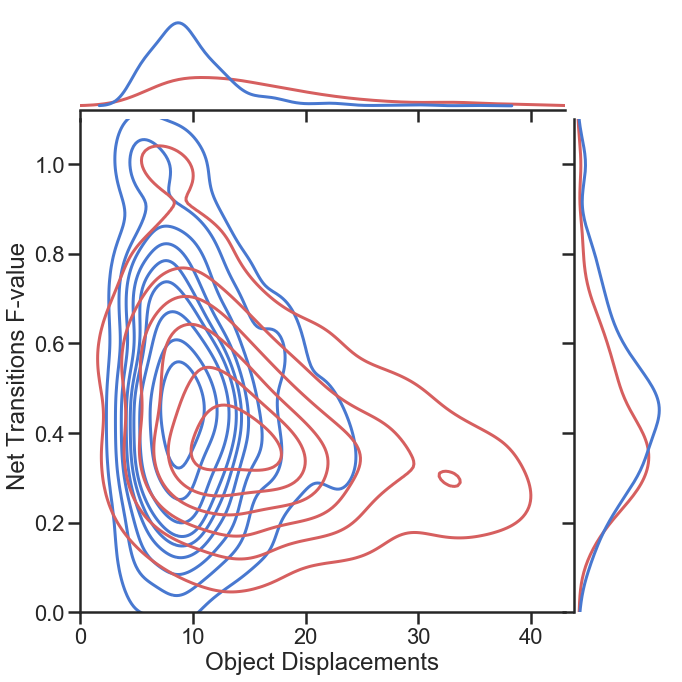

In [385]:
sns.set(context = "poster", style="ticks", palette='muted', font_scale=1,)

ax = sns.jointplot(
    data=sym_execution_df.query('grasp_num<=40 and grasp_num >= 5'),
    y='sym_index',
    x='grasp_num',
    hue='trial_type',
    kind='kde',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    height=10,
    aspect=1,
    space=0.1,
    legend=False

)
ax.ax_marg_y.set_yticks(np.arange(0, 1.1, 0.2))
ax.ax_joint.set_xticks(np.arange(0, 41, 10))
ax.ax_marg_y.set_ylim((0, 1.1))
ax.ax_marg_x.set_xlim((0, 43))
ax.ax_joint.set_xlabel('Object Displacements')
ax.ax_joint.set_ylabel('Net Transitions F-value');

plt.savefig(f'{PLOT_PATH}gaze_guidance_v_grasps_kde_execution', transparent=True, bbox_inches='tight', quality=90)

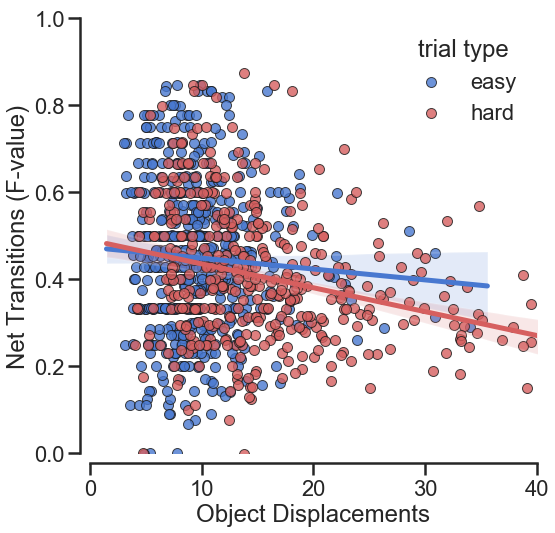

In [389]:
sns.set(context = "poster", style="ticks", palette="muted", rc={'figure.figsize':(8,8)})
sym_execution_df = sym_execution_df.query('sym_index != 1')
ax = sns.regplot(
    data=sym_execution_df.query('grasp_num <= 40 and grasp_num >= 4 and trial_type=="easy"'),
    y='sym_index',
    x='grasp_num',
    color='b',    
    y_jitter=0.001,
    x_jitter=1,
    ci=95,
    order=1,
    truncate=False,
    scatter_kws={"s": 100, 'edgecolors':'k', 'linewidths': 1},
    line_kws={'linewidth': 5},
    label='easy'
)

ax = sns.regplot(
    data=sym_execution_df.query('grasp_num <= 40 and  grasp_num >= 4 and trial_type=="hard"'),
    y='sym_index',
    x='grasp_num',
    color='r',    
    y_jitter=0.001,
    x_jitter=1,
    ci=95,
    order=1,
    truncate=False,
    scatter_kws={"s": 100, 'edgecolors':'k', 'linewidths': 1},
    line_kws={'linewidth': 5},
    label='hard',
    ax=ax
)
sns.despine(offset=10)
ax.set(
    xlabel='Object Displacements',
    ylabel='Net Transitions (F-value)',
    ylim=(0,1),
    xlim=(0,40)    
)
ax.legend(title='trial type', frameon=False)

plt.savefig(f'{PLOT_PATH}gaze_guidance_v_grasps_execution', transparent=True, bbox_inches='tight', quality=90)

In [388]:
tmpdf = sym_execution_df.query('grasp_num >= 4 and trial_type=="hard"').dropna()

print(f'Hard trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

tmpdf = sym_execution_df.query('grasp_num >= 4 and trial_type=="easy"').dropna()

print(f'Easy trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

Hard trial:(-0.25969083289433237, 4.6710288085823104e-08)
Easy trial:(-0.05852312167179974, 0.16666459828102664)


## calculate T50 for the ROIs

In [314]:
t50_df = (
    eye_execution_df
    .sort_values('timestamp_dt')
#     .query('grasp_num == 10')
    .query('is_fixation == True and obj_fix_dur >= 0.1 and obj_fix_dur <= 2 ')
    .drop_duplicates(
        subset=['subject_id', 'trial_num', 'trial_type', 'grasp_num', 
                'is_fixation', 'obj_fix_dur', 'fix_type',], 
        keep='first') 
    .dropna(subset=['fix_type'])
    .groupby(['subject_id', 'trial_type', 'trial_num', 'grasp_num', 'fix_type'],)
    .first()
    .reset_index()
#     .agg({'time_off_grasp':['mean', 'std', 'size']})
#     .reset_index()
    
)

t50_df.head()

,subject_id,trial_type,trial_num,grasp_num,fix_type,index,timestamp_dt,is_fixation,eye_hit,obj_fix_dur,time_on_grasp
0,2006.0,easy,5.0,1,current_TO,5613,1970-01-01 00:00:07.633999825,True,Cube_Yellow,0.277826,0.000000
1,2006.0,easy,5.0,1,current_TS,5669,1970-01-01 00:00:08.311912537,True,1_3,0.456420,0.217930
2,2006.0,easy,5.0,1,next_TO,5768,1970-01-01 00:00:09.411965370,True,Sphere_Green,0.133228,0.571565
3,2006.0,easy,5.0,2,other,5921,1970-01-01 00:00:12.610662460,True,1_2,0.200539,0.406811
4,2006.0,easy,5.0,2,prev_TO,5924,1970-01-01 00:00:12.643841743,True,2_2,0.200539,0.437900


,subject_id,trial_type,trial_num,fix_type,group_size
0,2006.0,easy,5.0,current_TO,0.277778
1,2006.0,easy,5.0,current_TS,0.194444
2,2006.0,easy,5.0,next_TO,0.055556
3,2006.0,easy,5.0,next_TS,0.055556
4,2006.0,easy,5.0,other,0.250000
...,...,...,...,...,...
6076,2062.0,hard,21.0,next_TO,0.061538
6077,2062.0,hard,21.0,next_TS,0.025641
6078,2062.0,hard,21.0,other,0.251282
6079,2062.0,hard,21.0,prev_TO,0.158974


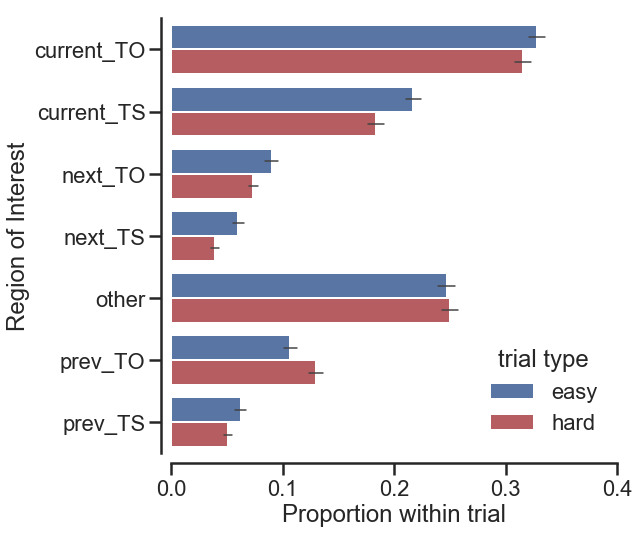

In [327]:
t_desc = t50_df.groupby(['subject_id','trial_type','trial_num','fix_type']).size()
# display(t_desc)
t_desc = t_desc.groupby(level=[0,1,2]).apply(lambda x: x/float(x.sum())).reset_index(name='group_size')
display(t_desc)
sns.set(style='ticks', context='poster', font_scale=1)
_, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    data=t_desc,
    x='group_size',
    y='fix_type',
    hue='trial_type',
    palette=['b', 'r'],
    dodge=0.1,
    ci=99,
#     scale=0.5,
#     capsize=0.2,
    errwidth=1.5,
#     join=False,
    ax=ax    
)
ax.set(
    ylabel='Region of Interest',
    xlabel='Proportion within trial',
    xlim=(0,0.4)
)
ax.legend(title='trial type', frameon=0)
sns.despine(offset=10)

plt.savefig(f'{PLOT_PATH}first_fix_roi_execution', transparent=True, bbox_inches='tight', quality=90)

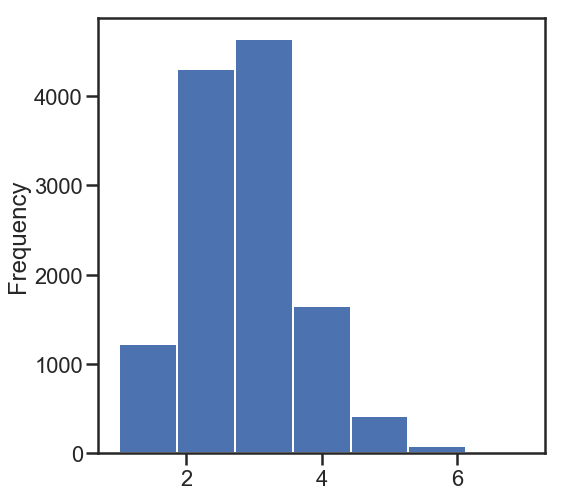

In [328]:
t = (
    t50_df
    .groupby(['subject_id', 'trial_type', 'trial_num', 'grasp_num'])
    .fix_type
    .size()
    .reset_index(name='group_size')
)
t.group_size.plot(kind='hist', bins=7)

In [58]:
tmp = t50_df.merge(t, on=['subject_id', 'trial_type', 'trial_num'])
tmp.query('group_size==7').head(10)

,subject_id,trial_type,trial_num,fix_type,time_on_grasp,group_size
0,2006.0,easy,5.0,current_TO,1.033109,7
1,2006.0,easy,5.0,current_TS,0.910668,7
2,2006.0,easy,5.0,next_TO,1.616403,7
3,2006.0,easy,5.0,next_TS,1.169648,7
4,2006.0,easy,5.0,other,1.392826,7
5,2006.0,easy,5.0,prev_TO,1.222071,7
6,2006.0,easy,5.0,prev_TS,1.660556,7
21,2006.0,easy,10.0,current_TO,0.342047,7
22,2006.0,easy,10.0,current_TS,0.624234,7
23,2006.0,easy,10.0,next_TO,0.344670,7


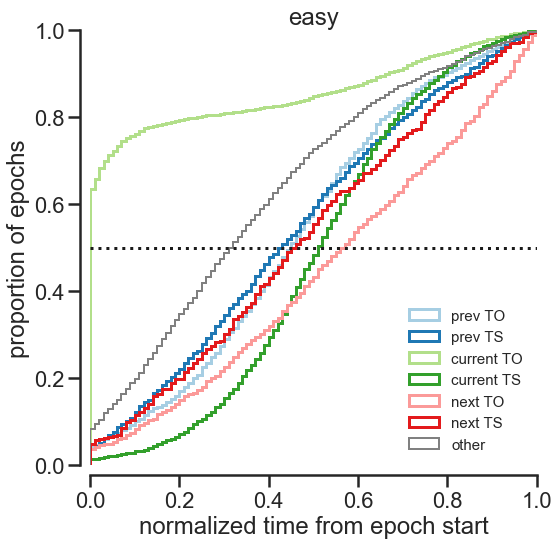

In [311]:
sns.set(context='poster', style='ticks', palette='Paired')
_, ax = plt.subplots(figsize=(8,8))
time_limit = 1.
n_bins = np.arange(0,1.3, 0.01)
trial_type='easy'

# previous TO and previous TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "prev_TO" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('fix_type == "prev_TS" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TS', ax=ax, lw=3)
)

# current TO and current TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TO" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TS" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TS', ax=ax, lw=3)
)

# next TO and next TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TO" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TS" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TS', ax=ax, lw=3)
)

ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "other" and time_on_grasp <=@time_limit')
    .time_on_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='other', color='grey',)
)

ax.axhline(0.50, ls=':', color='k')
ax.legend(loc='lower right', fontsize=15, frameon=False)
ax.set(
    xlim=(0, 1.),
    ylim=(0,1),
    title=trial_type,
    xlabel='normalized time from epoch start',
    ylabel='proportion of epochs'
    
)
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}t50_{trial_type}_execution', transparent=True, bbox_inches='tight', quality=90)

,subject_id,trial_type,trial_num,fix_type,t50
0,2006.0,easy,5.0,current_TO,0.000000
1,2006.0,easy,5.0,current_TS,0.412284
2,2006.0,easy,5.0,next_TO,0.641753
3,2006.0,easy,5.0,next_TS,0.644654
4,2006.0,easy,5.0,other,0.406811
...,...,...,...,...,...
6076,2062.0,hard,21.0,next_TO,0.413731
6077,2062.0,hard,21.0,next_TS,0.393593
6078,2062.0,hard,21.0,other,0.254122
6079,2062.0,hard,21.0,prev_TO,0.461357


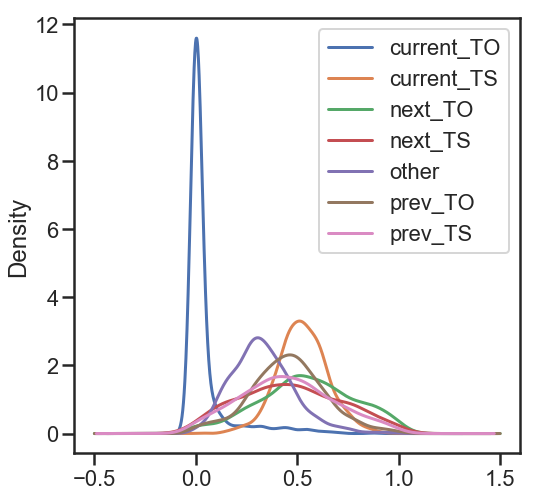

In [329]:
t = (
    t50_df
    .groupby(['subject_id', 'trial_type', 'trial_num', 'fix_type'])
    .time_on_grasp
    .apply(lambda x: np.quantile(x, 0.5))
    .reset_index(name='t50')
    
)
display(t)
t.groupby('fix_type').t50.plot(kind='kde', legend=True);

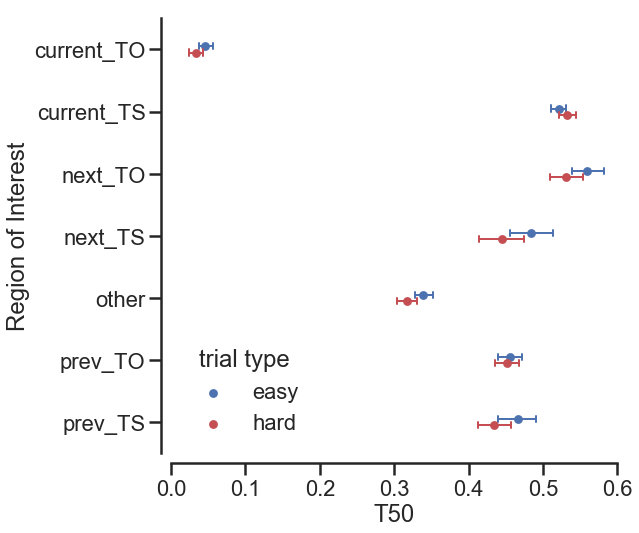

In [330]:
sns.set(style='ticks', context='poster', font_scale=1)
_, ax = plt.subplots(figsize=(8, 8))
ax = sns.pointplot(
    data=t,
    y='fix_type', 
    order=['current_TO', 'current_TS', 'next_TO', 'next_TS',  'other', 'prev_TO', 'prev_TS', ],
    x='t50',
    hue='trial_type',
    palette=['b', 'r'],
    dodge=0.1,
    ci=95,
    scale=0.5,
    capsize=0.1,
    errwidth=2,
    join=False,
    fillstype='none',
    ax=ax
)
ax.set(
    xlim=(0,0.6),
    xlabel='T50',
    ylabel='Region of Interest'
)
ax.legend(frameon=0, title='trial type', loc='best')
sns.despine(offset=10)

plt.savefig(f'{PLOT_PATH}t50_subject_execution', transparent=True, bbox_inches='tight', quality=90)

# Transition of fixations between end of previous grasp and start of current grasp

In [13]:
offset = 0.

valid_objs = [
    'Cube_Blue', 'Cube_Green', 'Cube_Red', 'Cube_Yellow', 
    'Cylinder_Blue', 'Cylinder_Green', 'Cylinder_Red','Cylinder_Yellow', 
    'Sphere_Blue', 'Sphere_Green', 'Sphere_Red', 'Sphere_Yellow', 
    'Tetraeder_Blue', 'Tetraeder_Green', 'Tetraeder_Red', 'Tetraeder_Yellow'
]

shelf_dict = {
    k:v 
    for k,v in 
    zip(
        sorted(samples_df.query('eye_shelf_hit!="ERROR"').eye_shelf_hit.dropna().unique()), 
        np.arange(0,25)
       )
}

shelf_locs = list(shelf_dict.keys())

#number of subjects the mp can handle
subjects = samples_df.subject_id.unique()[:2]
display(subjects)
grp_cols = ['subject_id', 'trial_num', 'trial_type']
eye_planning_df = (
    pandas_mp_apply(
        samples_df
#         .query('subject_id in @subjects')
        .reset_index()
        .groupby(grp_cols),
        partial(eye_transitions_planning, valid_objs=valid_objs, shelf_locs=shelf_locs, offset=offset)
    )
)
display(eye_planning_df.head())

eye_planning_df = eye_planning_df.reset_index()

array([2006., 2007.])

timestamp_dt  is_fixation  \
subject_id trial_num trial_type                                              
2006.0     2.0       hard       1970-01-01 00:01:17.879341125         True   
                     hard       1970-01-01 00:01:17.891799927        False   
                     hard       1970-01-01 00:01:17.901412964         True   
                     hard       1970-01-01 00:01:17.911552429         True   
                     hard       1970-01-01 00:01:17.922264099         True   

                                         eye_hit  obj_fix_dur fix_type  \
subject_id trial_num trial_type                                          
2006.0     2.0       hard        Tetraeder_Green     0.009972  prev_TO   
                     hard                    NaN     0.000000      NaN   
                     hard                    2_3     0.043694  prev_TS   
                     hard                    2_3     0.043694  prev_TS   
                     hard                    2_3     0.043694  prev_TS   

                                 time_on_grasp  time_off_grasp  grasp_num  \
subject_id trial_num trial_type                                             
2006.0     2.0       hard            -2.931923        0.000000          1   
                     hard            -2.919464        0.004249          1   
                     hard            -2.909851        0.007528          1   
                     hard            -2.899712        0.010986          1   
                     hard            -2.889000        0.014640          1   

                                                  grasp_onset  
subject_id trial_num trial_type                                
2006.0     2.0       hard       1970-01-01 00:01:20.811264038  
                     hard       1970-01-01 00:01:20.811264038  
                     hard       1970-01-01 00:01:20.811264038  
                     hard       1970-01-01 00:01:20.811264038  
                     hard       1970-01-01 00:01:20.811264038

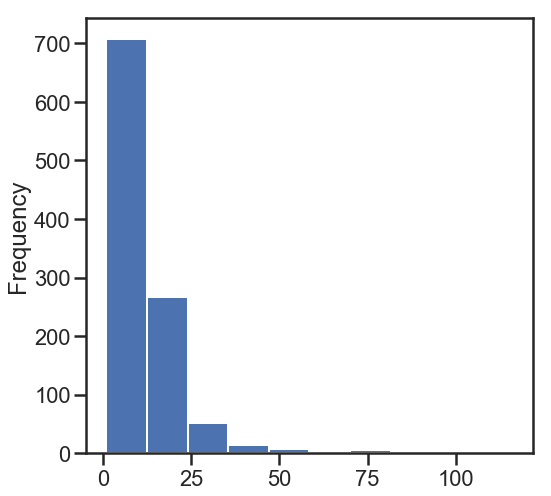

In [187]:
eye_planning_df.groupby(['subject_id', 'trial_num']).grasp_num.max().plot(kind='hist')

## calculate transition matrices and symmetry indices per trial per subject

In [14]:
sym_planning_df = pd.DataFrame()

for subject_id in eye_planning_df.subject_id.unique():
    tm_df = eye_planning_df.query('subject_id == @subject_id')
    PLOT_PATH_transition = f'./transit_final/{int(subject_id)}/'
    
    sym_dict = plot_net_transition_per_trial(tm_df, PLOT_PATH_transition, plot=False)
    
    tmpdf = pd.DataFrame.from_dict(sym_dict)
    tmpdf['subject_id'] = subject_id
    sym_planning_df = pd.concat([sym_planning_df, tmpdf], ignore_index=True)
    

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log2
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in multiply
C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\ipykernel_launcher.py:66: RuntimeWarning: invalid value encountered in double_scalars


C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\matplotlib\contour.py:1000: UserWarning: The following kwargs were not used by contour: 'aspect'
  s)


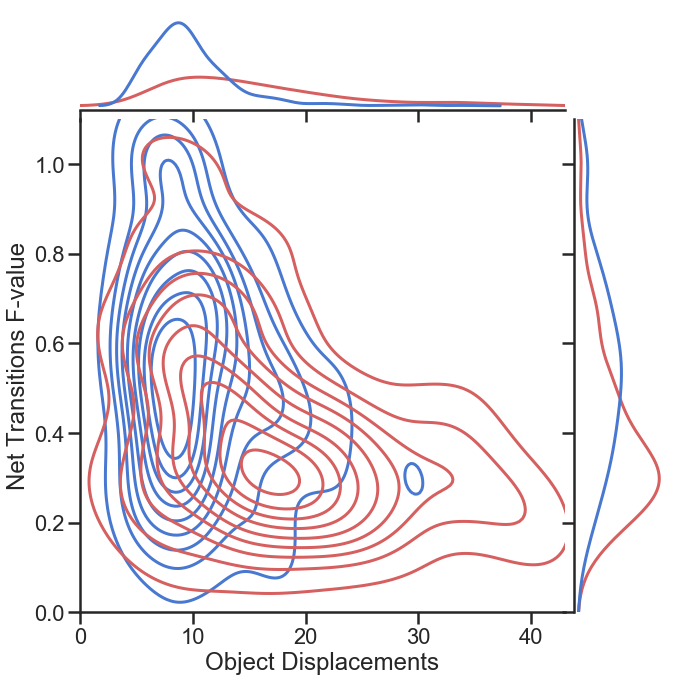

In [25]:
sns.set(context = "poster", style="ticks", palette='muted', font_scale=1,)

ax = sns.jointplot(
    data=sym_planning_df.query('grasp_num<=40 and grasp_num >= 5'),
    y='sym_index',
    x='grasp_num',
    hue='trial_type',
    kind='kde',
    hue_order=['easy', 'hard'],
    palette=['b', 'r'],
    height=10,
    aspect=1,
    space=0.1,
    legend=False

)
ax.ax_marg_y.set_yticks(np.arange(0, 1.1, 0.2))
ax.ax_joint.set_xticks(np.arange(0, 41, 10))
ax.ax_marg_y.set_ylim((0, 1.1))
ax.ax_marg_x.set_xlim((0, 43))
ax.ax_joint.set_xlabel('Object Displacements')
ax.ax_joint.set_ylabel('Net Transitions F-value');

plt.savefig(f'{PLOT_PATH}gaze_guidance_v_grasps_kde', transparent=True, bbox_inches='tight', quality=90)

,trial_num,grasp_num,sym_index,trial_type,entropy,subject_id
0,2.0,8,NaN,hard,"[nan, nan, nan]",2006.0
1,3.0,7,NaN,hard,"[nan, nan, nan, nan]",2006.0
3,5.0,13,NaN,easy,"[nan, nan, nan, nan, nan, nan]",2006.0
4,6.0,8,NaN,easy,"[nan, nan, nan, nan, nan]",2006.0
5,7.0,9,NaN,easy,"[nan, nan, nan]",2006.0
...,...,...,...,...,...,...
1046,14.0,7,NaN,hard,"[nan, nan, nan, nan, nan, nan, nan]",2062.0
1048,16.0,2,NaN,easy,"[nan, nan]",2062.0
1050,18.0,11,NaN,hard,"[nan, nan, nan, nan, nan, nan, nan]",2062.0
1051,19.0,2,NaN,easy,[nan],2062.0


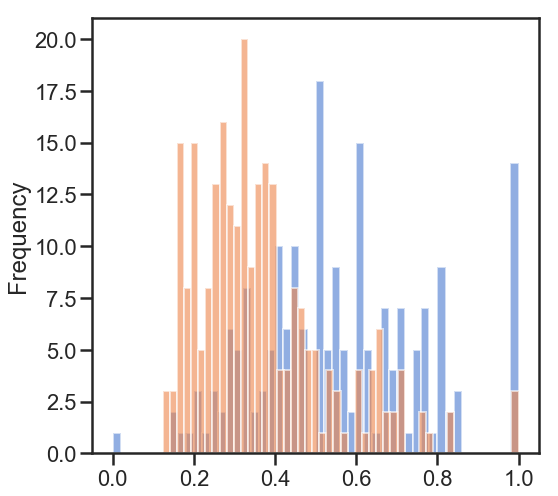

In [183]:
ax = sym_df.groupby('trial_type').sym_index.plot(kind='hist', bins=50, alpha=0.6)
sym_df.loc[sym_df.sym_index.isna()]

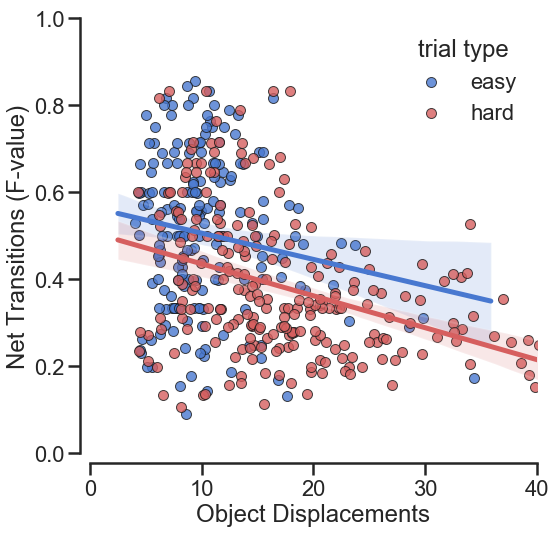

In [15]:
sns.set(context = "poster", style="ticks", palette="muted", rc={'figure.figsize':(8,8)})
sym_df = sym_planning_df.query('sym_index != 1')
ax = sns.regplot(
    data=sym_df.query('grasp_num <= 40 and grasp_num >= 5 and trial_type=="easy"'),
    y='sym_index',
    x='grasp_num',
    color='b',    
    y_jitter=0.001,
    x_jitter=1,
    ci=95,
    order=1,
    truncate=False,
    scatter_kws={"s": 100, 'edgecolors':'k', 'linewidths': 1},
    line_kws={'linewidth': 5},
    label='easy'
)

ax = sns.regplot(
    data=sym_df.query('grasp_num <= 40 and  grasp_num >= 5 and trial_type=="hard"'),
    y='sym_index',
    x='grasp_num',
    color='r',    
    y_jitter=0.001,
    x_jitter=1,
    ci=95,
    order=1,
    truncate=False,
    scatter_kws={"s": 100, 'edgecolors':'k', 'linewidths': 1},
    line_kws={'linewidth': 5},
    label='hard',
    ax=ax
)
sns.despine(offset=10)
ax.set(
    xlabel='Object Displacements',
    ylabel='Net Transitions (F-value)',
    ylim=(0,1),
    xlim=(0,40)    
)
ax.legend(title='trial type', frameon=False)

plt.savefig(f'{PLOT_PATH}gaze_guidance_v_grasps', transparent=True, bbox_inches='tight', quality=90)

In [17]:
tmpdf = sym_planning_df.query('grasp_num >= 5 and trial_type=="hard"').dropna()

print(f'Hard trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

tmpdf = sym_planning_df.query('grasp_num >= 5 and trial_type=="easy"').dropna()

print(f'Easy trial:{scipy.stats.pearsonr(tmpdf.sym_index.values, tmpdf.grasp_num.values)}')

Hard trial:(-0.3622456457508331, 1.7600065403731682e-09)
Easy trial:(-0.2124279580663424, 0.0025932534570233963)


## Calculate and Plot T50 for the regions of interest

In [331]:
t50_df = (
    eye_planning_df
    .sort_values('timestamp_dt')
#     .query('grasp_num == 10')
    .query('is_fixation == True and obj_fix_dur >= 0.1 and obj_fix_dur <= 2 ')
    .drop_duplicates(
        subset=['subject_id', 'trial_num', 'trial_type', 'grasp_num', 
                'is_fixation', 'obj_fix_dur', 'fix_type',], 
        keep='first') 
    .dropna(subset=['fix_type'])
    .groupby(['subject_id', 'trial_type', 'trial_num', 'grasp_num', 'fix_type'],)
    .first()
#     .agg({'time_off_grasp':['mean', 'std', 'size']})
    .reset_index()
    
)
# t50_df = (
#     tmpdf
#     .groupby(['subject_id', 'trial_type', 'trial_num', 'grasp_num', 'fix_type'],)
#     .first()
#     .reset_index()
# )
# display(t50_df)
# t50_df.shape
# tmp = t50_df.groupby(['subject_id', 'trial_type', 'trial_num']).fix_type.size().reset_index(name='size')
# t50_df = t50_df.merge(tmp, on=['subject_id', 'trial_type', 'trial_num']).query('size>=3')

# first_grasp = t50_df.groupby(['subject_id', 'trial_type', 'trial_num',]).grasp_num.transform(min)
# last_grasp = t50_df.groupby(['subject_id', 'trial_type', 'trial_num',]).grasp_num.transform(max)

# t50_df = t50_df[t50_df.grasp_num == first_grasp]

In [269]:
t50_df.groupby(['trial_type','fix_type']).time_off_grasp.describe()

count      mean       std  min       25%       50%  \
trial_type fix_type                                                          
easy       current_TO  4821.0  0.491211  0.271149  0.0  0.302039  0.508270   
           current_TS   591.0  0.396684  0.298029  0.0  0.122744  0.370747   
           next_TO      683.0  0.385710  0.278350  0.0  0.138249  0.373873   
           next_TS      306.0  0.389166  0.278233  0.0  0.147898  0.387912   
           other       3058.0  0.197979  0.234588  0.0  0.003584  0.111294   
           prev_TO     2286.0  0.085130  0.192994  0.0  0.000000  0.000000   
           prev_TS     1430.0  0.121991  0.208518  0.0  0.000000  0.019607   
hard       current_TO  6300.0  0.507643  0.285956  0.0  0.286743  0.527909   
           current_TS   935.0  0.431742  0.288459  0.0  0.163571  0.429452   
           next_TO     1474.0  0.368113  0.284220  0.0  0.114463  0.326967   
           next_TS      416.0  0.405498  0.286199  0.0  0.156883  0.373149   
           other       4632.0  0.163693  0.211753  0.0  0.005712  0.079416   
           prev_TO     3458.0  0.129956  0.238031  0.0  0.000000  0.000000   
           prev_TS     2242.0  0.153586  0.237026  0.0  0.000000  0.025851   

                            75%       max  
trial_type fix_type                        
easy       current_TO  0.700025  1.000000  
           current_TS  0.640835  1.000000  
           next_TO     0.598811  1.000000  
           next_TS     0.606113  1.000000  
           other       0.301309  1.000000  
           prev_TO     0.045446  1.000000  
           prev_TS     0.132106  0.987631  
hard       current_TO  0.744247  1.000000  
           current_TS  0.657475  1.000000  
           next_TO     0.598701  1.000000  
           next_TS     0.641090  1.000000  
           other       0.235795  1.000000  
           prev_TO     0.147776  1.000000  
           prev_TS     0.216158  1.000000

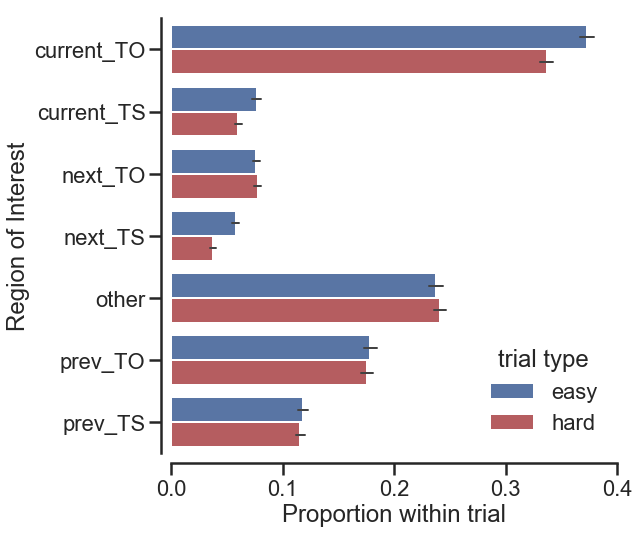

In [333]:
sns.set(style='ticks', palette='pastel')
t_desc = t50_df.groupby(['subject_id','trial_type','trial_num','fix_type']).size()
# display(t_desc)
t_desc = t_desc.groupby(level=[0,1,2]).apply(lambda x: x/float(x.sum())).reset_index(name='group_size')
# display(t_desc.head(14))
sns.set(style='ticks', context='poster', font_scale=1)
_, ax = plt.subplots(figsize=(8, 8))
sns.barplot(
    data=t_desc,
    x='group_size',
    y='fix_type',
    hue='trial_type',
    palette=['b', 'r'],
    dodge=0.1,
    ci=95,
#     scale=0.5,
#     capsize=0.2,
    errwidth=2,
#     join=False,
    ax=ax
    
)
ax.set(
    ylabel='Region of Interest',
    xlabel='Proportion within trial',
    xlim=(0,0.4)
)
ax.legend(title='trial type', frameon=0)
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}first_fix_roi_planning', transparent=True, bbox_inches='tight', quality=90)

In [18]:
%matplotlib inline

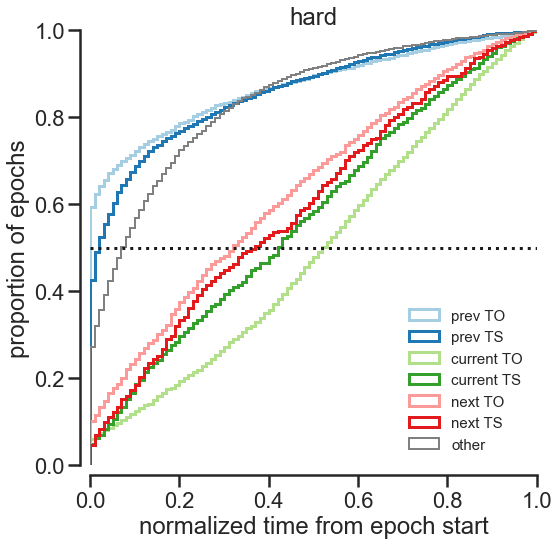

In [307]:
sns.set(context='poster', style='ticks', palette='Paired')
_, ax = plt.subplots(figsize=(8,8))
time_limit = 1
n_bins = np.arange(0, 1.3, 0.01)
trial_type='hard'

# previous TO and previous TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "prev_TO" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('fix_type == "prev_TS" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='prev TS', ax=ax, lw=3)
)

# current TO and current TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TO" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "current_TS" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='current TS', ax=ax, lw=3)
)

# next TO and next TS
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TO" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TO', ax=ax, lw=3)
)
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "next_TS" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='next TS', ax=ax, lw=3)
)
# ax = (
#     t50_df
#     .query('trial_type==@trial_type and fix_type == "same_feature" and time_off_grasp <=@time_limit')
#     .time_off_grasp
#     .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='same_feature',ls="--")
# )
ax = (
    t50_df
    .query('trial_type==@trial_type and fix_type == "other" and time_off_grasp <=@time_limit')
    .time_off_grasp
    .plot.hist(bins=n_bins, density=True, histtype='step', cumulative=True, label='other', color='grey',)
)

ax.axhline(0.50, ls=':', color='k')
ax.legend(loc='lower right', fontsize=15, frameon=False)
ax.set(
    xlim=(0, 1.),
    ylim=(0,1),
    title=trial_type,
    xlabel='normalized time from epoch start',
    ylabel='proportion of epochs'
    
)
sns.despine(offset=10)
plt.savefig(f'{PLOT_PATH}t50_{trial_type}_planning', transparent=True, bbox_inches='tight', quality=90)

,subject_id,trial_type,trial_num,fix_type,t50
0,2006.0,easy,5.0,current_TO,0.392800
1,2006.0,easy,5.0,current_TS,0.113747
2,2006.0,easy,5.0,next_TO,0.373556
3,2006.0,easy,5.0,next_TS,0.000000
4,2006.0,easy,5.0,other,0.127749
...,...,...,...,...,...
6069,2062.0,hard,21.0,next_TO,0.396862
6070,2062.0,hard,21.0,next_TS,0.092378
6071,2062.0,hard,21.0,other,0.064895
6072,2062.0,hard,21.0,prev_TO,0.006478


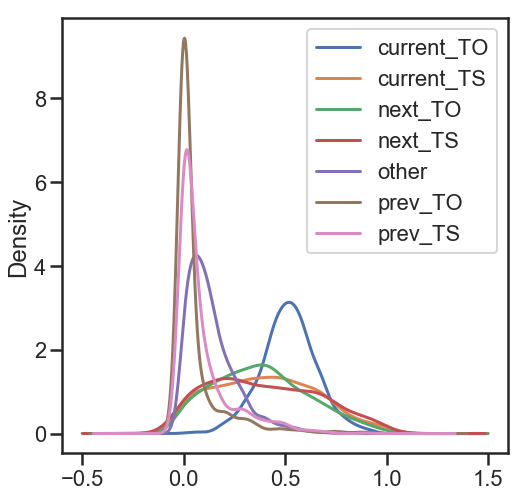

In [334]:
t = (
    t50_df
    .groupby(['subject_id', 'trial_type', 'trial_num', 'fix_type'])
    .time_off_grasp
    .apply(lambda x: np.quantile(x, 0.5))
    .reset_index(name='t50')
    
)
display(t)
t.groupby('fix_type').t50.plot(kind='kde', legend=True);

In [244]:
easy_cto = t.query('trial_type=="easy" and fix_type=="current_TO"').t50.values
easy_other = t.query('trial_type=="easy" and fix_type=="current_TS"').t50.values
print(scipy.stats.ttest_ind(easy_cto, easy_other))

hard_cto = t.query('trial_type=="hard" and fix_type=="current_TO"').t50.values
hard_other = t.query('trial_type=="hard" and fix_type=="current_TS"').t50.values
print(scipy.stats.ttest_ind(hard_cto, hard_other))

Ttest_indResult(statistic=8.923964768676335, pvalue=2.158128585834807e-18)
Ttest_indResult(statistic=9.075473748035986, pvalue=8.859534153895202e-19)


In [180]:
t.groupby('subject_id').trial_num.nunique().values

array([22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22,
       22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 22, 20],
      dtype=int64)

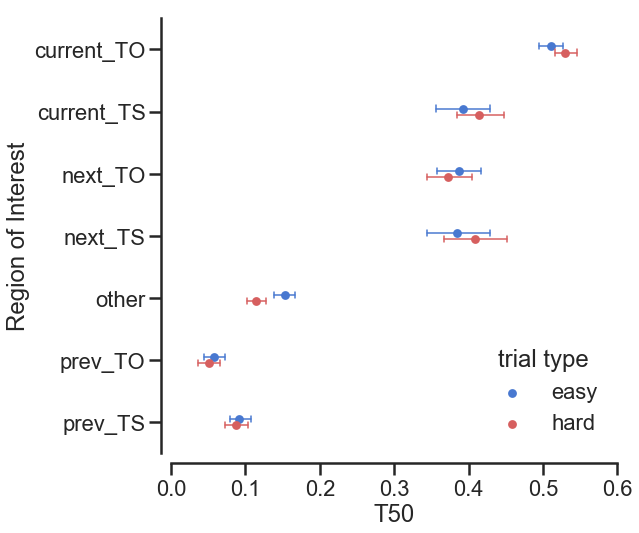

In [335]:
sns.set(style='ticks', palette='muted', context='poster', font_scale=1)
_, ax = plt.subplots(figsize=(8, 8))
ax = sns.pointplot(
    data=t,
    y='fix_type', 
    order=['current_TO', 'current_TS', 'next_TO', 'next_TS',  'other', 'prev_TO', 'prev_TS', ],
    x='t50',
    hue='trial_type',
    palette=['b', 'r'],
    markers=['o', 'o'],
    dodge=0.1,
    ci=99,
    scale=0.5,
    capsize=0.1,
    errwidth=1.5,
    join=False,
    ax=ax
)
ax.set(
    xlim=(0,0.6),
    xlabel='T50',
    ylabel='Region of Interest'
)
ax.legend(frameon=0, title='trial type', loc='lower right')
sns.despine(offset=10)

plt.savefig(f'{PLOT_PATH}t50_subject_planning', transparent=True, bbox_inches='tight', quality=90)

In [98]:
def get_grasps(sample_df):
    sample_df = sample_df.sort_values(by='timestamp_dt')
    grasp_times = (
        sample_df.query('grasp_onset_bool == 1')
        [['pickup_location', 'grasp', 'timestamp_dt']]
        .rename(columns=dict(
            timestamp_dt='on_time',
            pickup_location='on_loc',
            grasp='current_TO',
        ))
    )
    grasp_times['off_time'] = sample_df.query('grasp_end_bool == 1').timestamp_dt.values
    grasp_times['current_TS'] = sample_df.query('grasp_end_bool == 1').drop_location.values
    grasp_times = grasp_times.sort_values(by='on_time').reset_index(drop=True)

    grasp_times = grasp_times.drop_duplicates(subset = ['on_loc', 'current_TS', 'current_TO'], keep='first')

    grasp_times = grasp_times.query('on_loc != current_TS')
    grasp_times['between_grasp_duration'] = (grasp_times['on_time'].shift(-1) - grasp_times['on_time'])/np.timedelta64(1, 's')
    grasp_times['in_grasp_duration'] = (grasp_times['off_time'] - grasp_times['on_time'])/np.timedelta64(1, 's')
    grasp_times['off_on_time'] = (grasp_times['on_time'] - grasp_times['off_time'].shift(1))/np.timedelta64(1, 's')
    
    return grasp_times

grp_cols = ['subject_id', 'trial_num']
grasp_df = (
    samples_df
    .reset_index()
#         .query('subject_id == @subjects')
    .groupby(grp_cols)
    .apply(get_grasps)        
)

In [100]:
display(grasp_df.off_on_time.describe())

count    13443.000000
mean         3.123924
std          5.117498
min         -0.810375
25%          0.856108
50%          1.544029
75%          3.319623
max        123.617493
Name: off_on_time, dtype: float64

C:\Users\akeshava\.conda\envs\conda_ergovr\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


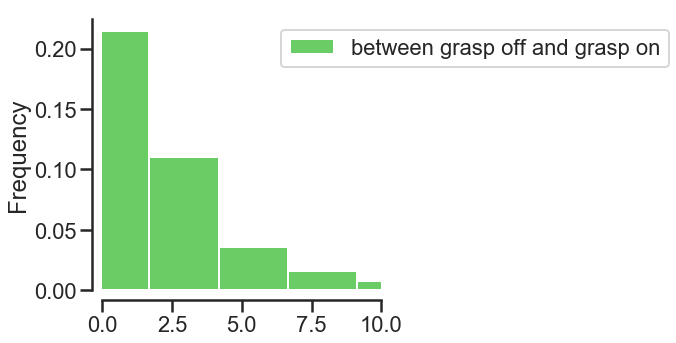

In [110]:
sns.set(context = "poster", style="ticks", palette="muted", font_scale=1, rc={'figure.figsize':(5,5)})

# ax = (
#     grasp_df
# #     .query('grasp_duration <= 20')
#     .in_grasp_duration
#     .plot(kind='kde', color='r', label='grasp duration')
# )

# ax = (
#     grasp_df
# #     .query('grasp_duration <= 20')
#     .between_grasp_duration
#     .plot(kind='kde', color='b', label='between grasp duration', ax=ax)
# )
ax = (
    grasp_df
#     .query('grasp_duration <= 20')
    .off_on_time
    .plot(kind='hist', color='g', label='between grasp off and grasp on', bins=50, normed=True)
)
ax.set(
#     ylim=(0, 0.6),
    xlim=(0,10)
)
ax.legend(bbox_to_anchor=[0.6,1])
sns.despine(offset=10)


In [63]:
grasp_df.head()

on_loc       current_TO                       on_time  \
subject_id trial_num                                                           
2010.0     2.0       0    3_2        Cube_Blue 1970-01-01 00:00:07.592772484   
                     1    4_3         Cube_Red 1970-01-01 00:00:14.967687607   
                     2    5_4   Tetraeder_Blue 1970-01-01 00:00:23.364267349   
                     3    1_5  Tetraeder_Green 1970-01-01 00:00:27.484975815   
                     4    4_2     Sphere_Green 1970-01-01 00:00:37.514396667   

                                            off_time current_TS  \
subject_id trial_num                                              
2010.0     2.0       0 1970-01-01 00:00:09.413703918        1_1   
                     1 1970-01-01 00:00:16.378602982        4_4   
                     2 1970-01-01 00:00:24.319387436        5_5   
                     3 1970-01-01 00:00:31.605339050        1_3   
                     4 1970-01-01 00:00:38.524742126        4_3   

                        between_grasp_duration  in_grasp_duration  
subject_id trial_num                                               
2010.0     2.0       0                7.374915           1.820931  
                     1                8.396580           1.410915  
                     2                4.120708           0.955120  
                     3               10.029421           4.120363  
                     4               11.139454           1.010345